In [125]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "figure.figsize": (10, 6),
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "lines.linewidth": 2,
    }
)

In [126]:
%matplotlib inline

### Gillespie's Algorithm

In [127]:
import numpy as np
from scipy.integrate import solve_ivp


def sir_rhs(t, y, beta, gamma, mu, N):
    """
    Frequency-dependent SIR with COUNTS (X,Y,Z) and fixed population N.
    dX/dt = -beta * X * Y / N
    dY/dt =  beta * X * Y / N - gamma * Y
    dZ/dt =  gamma * Y
    """
    X, Y, Z = y

    dX = mu * N - beta * X * Y / N - mu * X
    dY = beta * X * Y / N - gamma * Y - mu * Y
    dZ = gamma * Y - mu * Z
    return [dX, dY, dZ]


def integrate_sir(
    beta, gamma, mu, N, X0, Y0, Z0, t_span=(0.0, 160.0), num_points=1000, method="RK45"
):
    """
    Minimal integrator wrapper for counts-based frequency-dependent SIR.
    Returns dict with t, X, Y, Z (arrays).
    """

    y0 = [float(X0), float(Y0), float(Z0)]
    t_eval = np.linspace(t_span[0], t_span[1], num_points)

    sol = solve_ivp(
        lambda t, y: sir_rhs(t, y, beta, gamma, mu, N),
        t_span,
        y0,
        t_eval=t_eval,
        method=method,
        rtol=1e-8,
        atol=1e-10,
    )

    # Numerical safety: clip tiny negatives from solver noise

    Y = np.clip(sol.y, 0.0, None)
    return {"t": sol.t, "X": Y[0], "Y": Y[1], "Z": Y[2]}


def gillespie_sir(beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=None):
    """
    infectionL (X - 1, Y + 1), rate_1 = beta * X * Y / N
    recovery: (Y - 1, Z + 1), rate_2 = gamma * Y
    birth:  (X + 1), rate_3 = mu * N
    deathX: (X - 1), rate_4 = mu * X
    deathY: (Y - 1), rate_5 = mu * Y
    deathZ: (Z - 1), rate_6 = mu * Z
    """
    if rng is None:
        rng = np.random.default_rng()

    # Validate & coerce to ints

    X, Y, Z = int(X0), int(Y0), int(Z0)
    t = 0.0

    times = [0.0]
    X_hist, Y_hist, Z_hist = [X], [Y], [Z]

    while t < tmax and Y > 0:
        rate_I = beta * X * Y / N  # infection
        rate_R = gamma * Y
        rate_B = mu * N  # birth
        rate_DX = mu * X  # death of susceptible
        rate_DY = mu * Y  # death of infected
        rate_DZ = mu * Z  # death of recovered
        total_rate = rate_I + rate_R + rate_B + rate_DX + rate_DY + rate_DZ

        # exponential waiting time
        t += -np.log(rng.random()) / total_rate

        r = rng.random() * total_rate

        if r < rate_I:
            if X > 0:
                X -= 1
                Y += 1
        elif r < rate_I + rate_R:
            if Y > 0:
                Y -= 1
                Z += 1
        elif r < rate_I + rate_R + rate_B:
            X += 1
        elif r < rate_I + rate_R + rate_B + rate_DX:
            if X > 0:
                X -= 1
        elif r < rate_I + rate_R + rate_B + rate_DX + rate_DY:
            if Y > 0:
                Y -= 1
        else:
            if Z > 0:
                Z -= 1

        times.append(t)
        X_hist.append(X)
        Y_hist.append(Y)
        Z_hist.append(Z)

    return np.array(times), np.array(X_hist), np.array(Y_hist), np.array(Z_hist)

In [128]:
def resample_step(times, values, t_grid):
    """Piecewise-constant resampling of an event-driven trajectory."""

    out = np.empty_like(t_grid, dtype=float)
    j = 0
    curr = values[0]
    for k, tk in enumerate(t_grid):
        while j + 1 < len(times) and times[j + 1] <= tk:
            j += 1
            curr = values[j]
        out[k] = curr
    return out

In [129]:
# Compare stochastic and deterministic SIR models

beta = 0.5
gamma = 0.1
mu = 1 / 50
N = 1000
I0 = 10
S0 = N - I0
R0 = 0

t_span = (0.0, 160.0)
num_points = 1000
t_grid = np.linspace(t_span[0], t_span[1], num_points)

# Deterministic solution
det = integrate_sir(
    beta, gamma, mu, N, S0, I0, R0, t_span=t_span, num_points=num_points
)

# Stochastic replicates
n_runs = 200
I_paths = np.zeros((n_runs, num_points), dtype=float)

for r in range(n_runs):
    rng = np.random.default_rng(12345 + r)  # reproducible variety
    times, S_hist, I_hist, R_hist = gillespie_sir(
        beta, gamma, mu, N, S0, I0, R0, tmax=t_span[1], rng=rng
    )
    I_paths[r, :] = resample_step(times, I_hist, t_grid)

I_mean = I_paths.mean(axis=0)

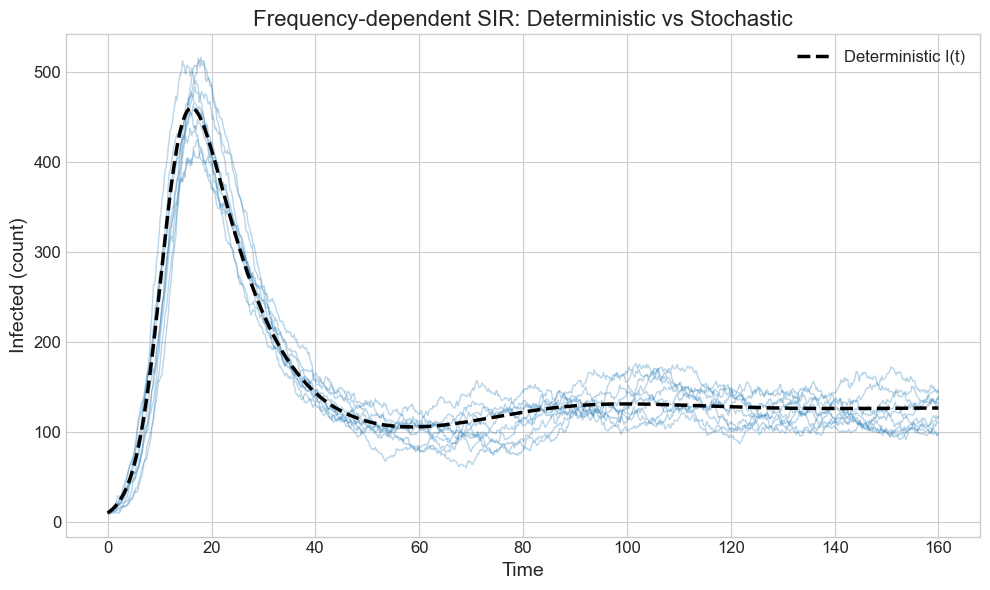

In [5]:
n_show = 10  # number of stochastic runs to show

fig, ax = plt.subplots()
for r in range(n_show):
    ax.plot(t_grid, I_paths[r, :], color="tab:blue", alpha=0.3, lw=1)

# Deterministic
ax.plot(det["t"], det["Y"], "k--", lw=2.5, label="Deterministic I(t)")

# Labels and legend
ax.set_xlabel("Time")
ax.set_ylabel("Infected (count)")
ax.set_title("Frequency-dependent SIR: Deterministic vs Stochastic")
ax.legend()

plt.tight_layout()
plt.show()

### Simulation Variability and Negative Co-variance

In [6]:
def run_ensemble(
    beta,
    gamma,
    mu,
    N,
    X0,
    Y0,
    Z0,
    t_span=(0.0, 160.0),
    num_points=1000,
    n_runs=200,
    seed0=12345,
):
    """
    Runs many Gillespie simulations and the deterministic ODE
    using counts (X,Y,Z). Returns t grid, deterministic curves,
    and stacked X/Y/Z paths.
    """
    # Use the counts-based integrator so keys are X,Y,Z
    det = integrate_sir(
        beta, gamma, mu, N, X0, Y0, Z0, t_span=t_span, num_points=num_points
    )
    t_grid = det["t"]

    X_paths = np.zeros((n_runs, num_points))
    Y_paths = np.zeros((n_runs, num_points))
    Z_paths = np.zeros((n_runs, num_points))

    for r in range(n_runs):
        rng = np.random.default_rng(seed0 + r)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax=t_span[1], rng=rng
        )
        X_paths[r, :] = resample_step(times, X_hist, t_grid)
        Y_paths[r, :] = resample_step(times, Y_hist, t_grid)
        Z_paths[r, :] = resample_step(times, Z_hist, t_grid)

    return t_grid, det, X_paths, Y_paths, Z_paths

In [7]:
def ensemble_stats(X_paths, Y_paths, Z_paths):
    """Compute time-wise mean/variance for X, Y, Z, and Cov[X,Y] (counts)."""
    X_mean = X_paths.mean(axis=0)
    Y_mean = Y_paths.mean(axis=0)
    Z_mean = Z_paths.mean(axis=0)

    X_var = X_paths.var(axis=0, ddof=1)
    Y_var = Y_paths.var(axis=0, ddof=1)
    Z_var = Z_paths.var(axis=0, ddof=1)

    XY_mean = (X_paths * Y_paths).mean(axis=0)
    XY_cov = XY_mean - X_mean * Y_mean

    return {
        "X_mean": X_mean,
        "Y_mean": Y_mean,
        "Z_mean": Z_mean,
        "X_var": X_var,
        "Y_var": Y_var,
        "Z_var": Z_var,
        "XY_cov": XY_cov,
    }

In [8]:
from math import ceil

beta = 0.5
gamma = 0.1
mu = 1 / 50
t_span = (0, 160)
num_points = 1000
n_runs = 200

N_list = [500, 1000, 2000, 5000, 10000]
I0_fixed = 5
i0_frac = I0_fixed / 5000

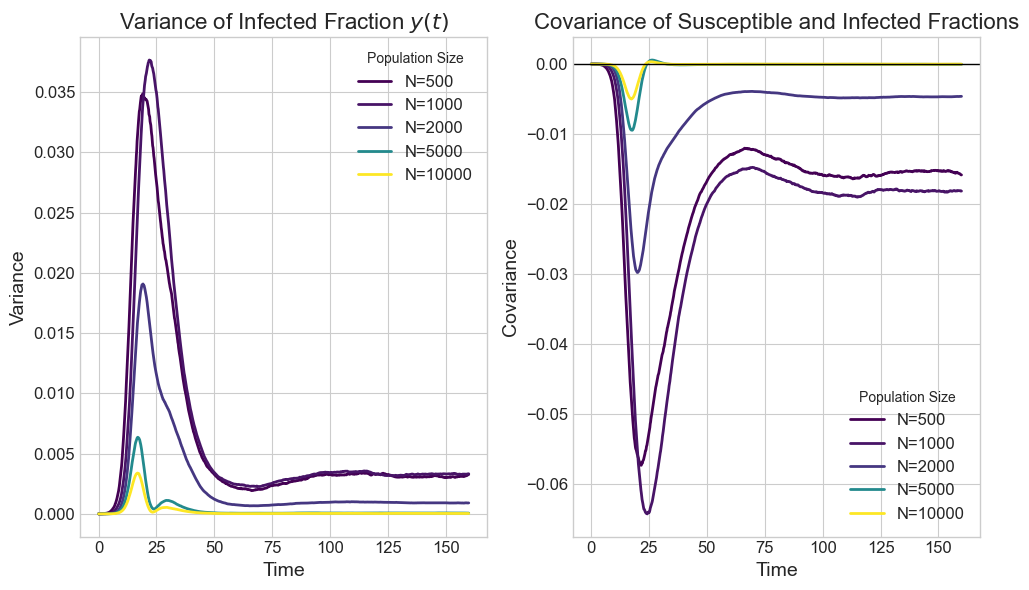

In [9]:
fig, (ax_var, ax_cov) = plt.subplots(1, 2)

Nmin, Nmax = min(N_list), max(N_list)

for N in N_list:
    # fixed initial fraction
    Y0 = max(1, int(ceil(i0_frac * N)))
    X0, Z0 = N - Y0, 0

    t, det, X_paths, Y_paths, Z_paths = run_ensemble(
        beta,
        gamma,
        mu,
        N,
        X0,
        Y0,
        Z0,
        t_span=t_span,
        num_points=num_points,
        n_runs=n_runs,
        seed0=6000,
    )

    # convert to fractions
    y_paths = Y_paths / N
    x_paths = X_paths / N

    # normalized stats
    y_var = y_paths.var(axis=0, ddof=1)
    xy_mean = (x_paths * y_paths).mean(axis=0)
    xy_cov = xy_mean - x_paths.mean(axis=0) * y_paths.mean(axis=0)

    color = plt.cm.viridis((N - Nmin) / (Nmax - Nmin))

    # Variance of infected fraction
    ax_var.plot(t, y_var, color=color, label=f"N={N}")

    # Covariance of susceptible vs infected fractions
    ax_cov.plot(t, xy_cov, color=color, label=f"N={N}")

ax_cov.axhline(0, color="k", lw=1)

ax_var.set_title("Variance of Infected Fraction $y(t)$")
ax_var.set_xlabel("Time")
ax_var.set_ylabel("Variance")

ax_cov.set_title("Covariance of Susceptible and Infected Fractions")
ax_cov.set_xlabel("Time")
ax_cov.set_ylabel("Covariance")

ax_var.legend(title="Population Size")
ax_cov.legend(title="Population Size")

plt.tight_layout()
plt.show()

In [10]:
from scipy.signal import find_peaks


def find_sir_equilibrium(beta, gamma, mu, N):
    """Find the endemic equilibrium for SIR with demography."""
    R0 = beta / (gamma + mu)
    if R0 <= 1.0:
        return (N, 0, 0)
    else:
        X_eq = N / R0
        Y_eq = mu * N * (R0 - 1) / beta
        Z_eq = N - X_eq - Y_eq
        return (X_eq, Y_eq, Z_eq)

In [11]:
def compute_psd(y_signal, dt):
    """
    FFT-based PSD with correct one-sided normalization.
    Uses second half (steady-state), mean removal, Hann window.
    Returns freqs (1/time) and PSD with units 'power per (1/time)'.
    """
    # Steady-state half
    mid = len(y_signal) // 2
    y_steady = y_signal[mid:]

    # Detrend (mean) and window
    y_centered = y_steady - np.mean(y_steady)
    window = np.hanning(len(y_centered))
    y_windowed = y_centered * window

    # FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(len(y_windowed), d=dt)

    Fs = 1.0 / dt
    psd = (np.abs(fft_vals) ** 2) / (Fs * np.sum(window**2))

    if len(psd) > 2:
        psd[1:-1] *= 2

    return freqs, psd

In [12]:
def analyze_resonance(beta, gamma, mu, N, n_runs=30, tmax=400):
    """
    Analyze stochastic resonance: run simulations and compute averaged PSD.
    """
    # Setup
    t_grid = np.linspace(0, tmax, 4000)
    dt = t_grid[1] - t_grid[0]
    X_eq, Y_eq, Z_eq = find_sir_equilibrium(beta, gamma, mu, N)

    X0, Y0, Z0 = int(X_eq), max(1, int(Y_eq)), int(Z_eq)

    all_psds = []
    all_trajectories = []

    for run in range(n_runs):
        rng = np.random.default_rng(1000 + run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=rng
        )
        Y_uniform = resample_step(times, Y_hist, t_grid)
        all_trajectories.append(Y_uniform)

        freqs, psd = compute_psd(Y_uniform / N, dt)
        all_psds.append(psd)

    avg_psd = np.mean(all_psds, axis=0)

    f_nyq = 0.5 / dt
    f_low = 1.0 / tmax
    f_high = min(0.1, 0.9 * f_nyq)
    mask = (freqs >= f_low) & (freqs <= f_high)

    peak_freq = None
    peak_power = None
    if np.any(mask):
        prom = np.percentile(avg_psd[mask], 85)
        peaks, properties = find_peaks(
            avg_psd[mask], prominence=max(1e-12, prom), width=1
        )
        if len(peaks) > 0:
            masked_psd = avg_psd[mask]
            best = peaks[np.argmax(masked_psd[peaks])]
            peak_freq = freqs[mask][best]
            peak_power = masked_psd[best]

    return {
        "freqs": freqs,
        "avg_psd": avg_psd,
        "peak_freq": peak_freq,
        "peak_power": peak_power,
        "trajectories": all_trajectories,
        "t_grid": t_grid,
        "Y_eq": Y_eq,
    }

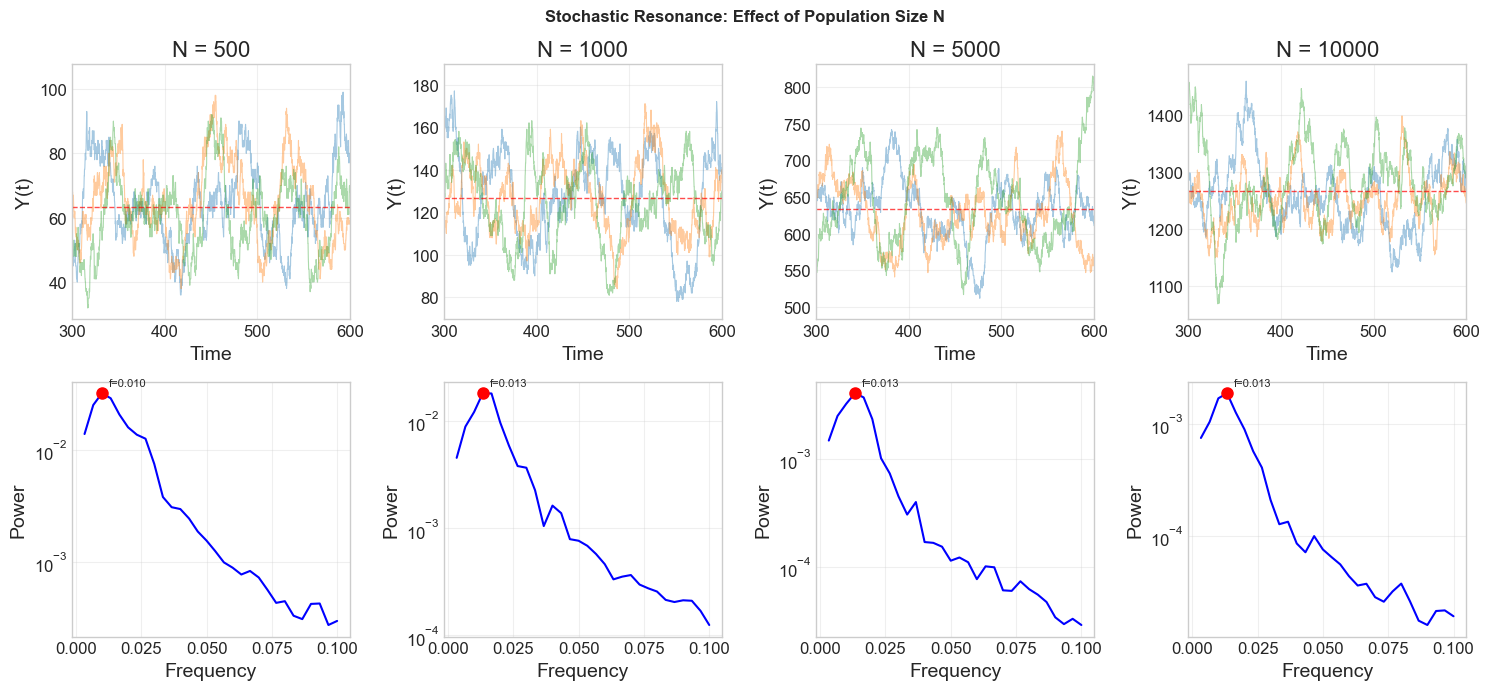

In [14]:
gamma = 0.1
mu = 1 / 50
N_values = [500, 1000, 5000, 10000]
beta = 0.5

fig, axes = plt.subplots(2, len(N_values), figsize=(15, 7))

resonance_results = []
for idx, N in enumerate(N_values):
    res = analyze_resonance(beta, gamma, mu, N, n_runs=20, tmax=600)
    resonance_results.append(res)

    # Top: Sample trajectories
    ax = axes[0, idx]
    for i in range(min(3, len(res["trajectories"]))):
        ax.plot(res["t_grid"], res["trajectories"][i], alpha=0.4, lw=0.8)
    ax.axhline(res["Y_eq"], ls="--", lw=1.0, alpha=0.7, color="red", label="Y*")
    ax.set_title(f"N = {N}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Y(t)")
    ax.set_xlim([300, 600])
    ax.grid(True, alpha=0.3)

    # Bottom: Power spectrum
    ax = axes[1, idx]
    mask = (res["freqs"] > 0) & (res["freqs"] < 0.1)
    ax.semilogy(res["freqs"][mask], res["avg_psd"][mask], "b-", lw=1.5)

    if res["peak_freq"] is not None:
        ax.plot(res["peak_freq"], res["peak_power"], "ro", markersize=8)
        ax.annotate(
            f"f={res['peak_freq']:.3f}",
            xy=(res["peak_freq"], res["peak_power"]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
        )

    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")
    ax.grid(True, alpha=0.3)

plt.suptitle("Stochastic Resonance: Effect of Population Size N", fontweight="bold")
plt.tight_layout()
plt.show()

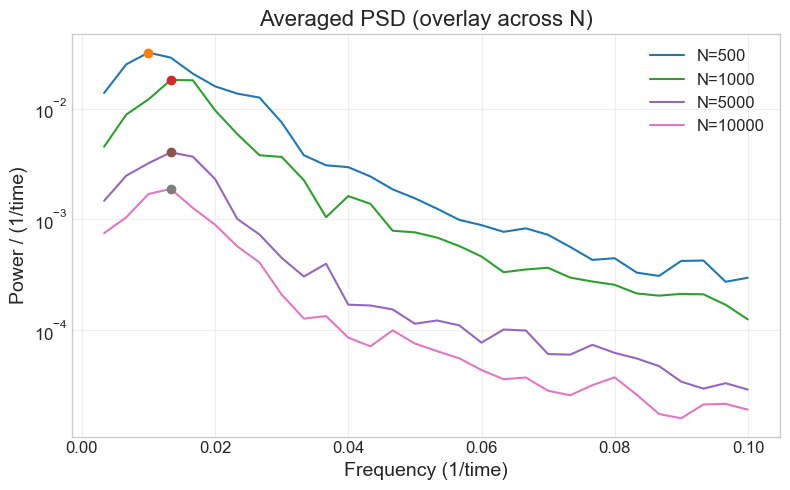

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
for N, res in zip(N_values, resonance_results):
    f_low, f_high = 1 / res["t_grid"][-1], 0.1
    mask = (res["freqs"] >= f_low) & (res["freqs"] <= f_high)
    ax.semilogy(res["freqs"][mask], res["avg_psd"][mask], lw=1.5, label=f"N={N}")
    if res["peak_freq"] is not None:
        ax.plot(res["peak_freq"], res["peak_power"], "o")

ax.set_xlabel("Frequency (1/time)")
ax.set_ylabel("Power / (1/time)")
ax.set_title("Averaged PSD (overlay across N)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

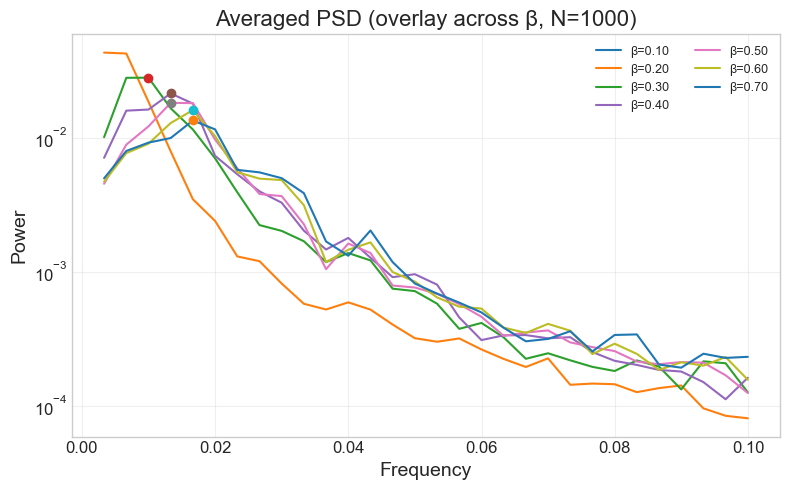

In [16]:
N_fixed = 1000
beta_grid = np.arange(0.1, 0.71, 0.1)
psd_by_beta = []

for b in beta_grid:
    res = analyze_resonance(b, gamma, mu, N_fixed, n_runs=20, tmax=600)
    psd_by_beta.append(res)

fig, ax = plt.subplots(figsize=(8, 5))
for b, res in zip(beta_grid, psd_by_beta):

    f_low, f_high = 1 / res["t_grid"][-1], 0.1
    mask = (res["freqs"] >= f_low) & (res["freqs"] <= f_high)
    ax.semilogy(res["freqs"][mask], res["avg_psd"][mask], lw=1.5, label=f"β={b:.2f}")
    if res["peak_freq"] is not None:
        ax.plot(res["peak_freq"], res["peak_power"], "o")

ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.set_title(f"Averaged PSD (overlay across β, N={N_fixed})")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

In [39]:
from joblib import Parallel, delayed


def analyze_transients_around_eq(
    beta, gamma, mu, N, n_runs=40, tmax=800, num_points=2000, burn_frac=0.5, seed0=2000
):
    eq = find_sir_equilibrium(beta, gamma, mu, N)
    if eq is None:
        return np.nan
    X_star, Y_star, Z_star = eq

    X0 = max(0, int(round(X_star)))
    Y0 = max(1, int(round(Y_star)))
    Z0 = max(0, int(round(Z_star)))

    t_grid = np.linspace(0.0, tmax, num_points)
    burn = int(burn_frac * num_points)

    overs = []
    for r in range(n_runs):
        rng = np.random.default_rng(seed0 + r)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax=tmax, rng=rng
        )
        Y_uni = resample_step(times, Y_hist, t_grid)  # counts
        peak_ss = float(np.max(Y_uni[burn:]))  # stationary window only
        os = max(0.0, (peak_ss - Y_star) / N)
        overs.append(os)

    return float(np.mean(overs))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.5min remaining:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


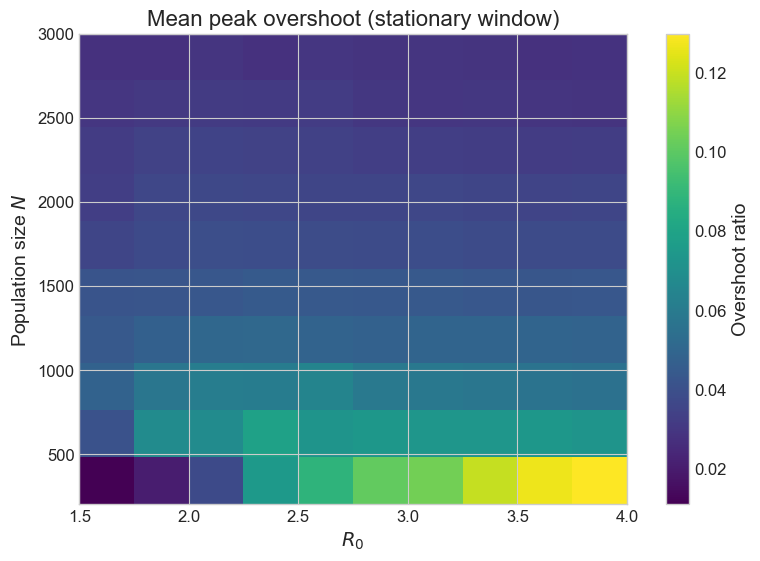

In [45]:
def sweep_mean_overshoot(
    N_grid,
    R0_grid,
    gamma,
    mu,
    n_runs=40,
    tmax=800,
    num_points=2000,
    burn_frac=0.5,
    n_jobs=-1,
):
    params = [(N, R0) for N in N_grid for R0 in R0_grid]

    def run_point(N, R0):
        if R0 <= 1.0:
            return np.nan
        beta = R0 * (gamma + mu)
        return analyze_transients_around_eq(
            beta,
            gamma,
            mu,
            N,
            n_runs=n_runs,
            tmax=tmax,
            num_points=num_points,
            burn_frac=burn_frac,
        )

    vals = Parallel(n_jobs=n_jobs, verbose=10, prefer="processes")(
        delayed(run_point)(N, R0) for (N, R0) in params
    )

    M, B = len(N_grid), len(R0_grid)
    return np.array(vals).reshape(M, B)


gamma, mu = 0.1, 1 / 50
N_grid = np.linspace(200, 3000, 10, dtype=int)
R0_grid = np.linspace(1.5, 10, 10)

mean_os = sweep_mean_overshoot(
    N_grid,
    R0_grid,
    gamma,
    mu,
    n_runs=40,
    tmax=800,
    num_points=2000,
    burn_frac=0.5,
    n_jobs=-1,
)

fig, ax = plt.subplots(figsize=(7.5, 5.5), constrained_layout=True)

im = ax.imshow(
    mean_os,
    origin="lower",
    aspect="auto",
    extent=[R0_grid[0], R0_grid[-1], N_grid[0], N_grid[-1]],
    cmap="viridis",
)
ax.set_title("Mean peak overshoot (stationary window)")
ax.set_xlabel(r"$R_0$")
ax.set_ylabel("Population size $N$")
c = plt.colorbar(im, ax=ax)
c.set_label("Overshoot ratio")

plt.show()

Equilibrium at N=100000, R0=4.0: (25000.0, 12499.999999999998, 62500.0)
Y* = 12500.00, Y0 = 12500


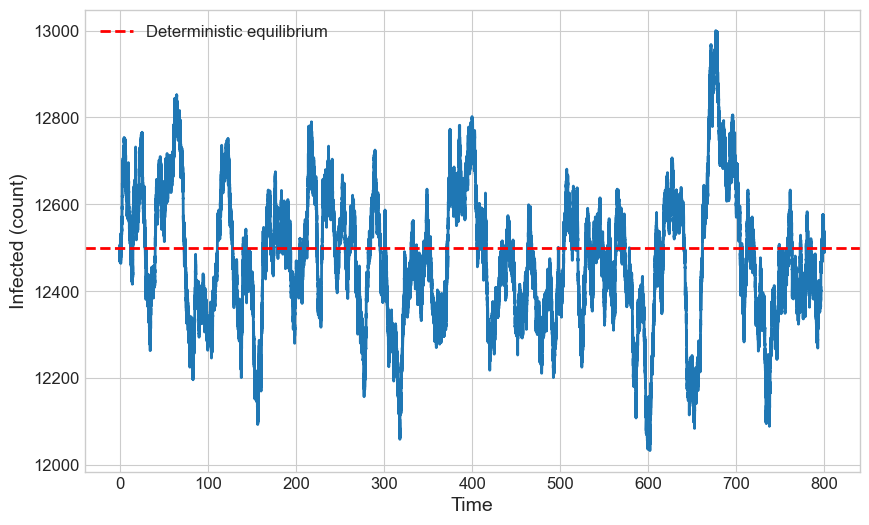

In [44]:
N, R0 = 100000, 4.0
beta = R0 * (gamma + mu)
eq = find_sir_equilibrium(beta, gamma, mu, N)
print(f"Equilibrium at N={N}, R0={R0}: {eq}")
print(f"Y* = {eq[1]:.2f}, Y0 = {max(1, int(round(eq[1])))}")

# Run one trajectory and plot it
rng = np.random.default_rng(2000)
times, X_hist, Y_hist, Z_hist = gillespie_sir(
    beta, gamma, mu, N, int(eq[0]), max(1, int(eq[1])), int(eq[2]), tmax=800, rng=rng
)
plt.xlabel("Time")
plt.ylabel("Infected (count)")
plt.plot(times, Y_hist)
plt.axhline(eq[1], color="red", linestyle="--", label="Deterministic equilibrium")
plt.legend()
plt.show()

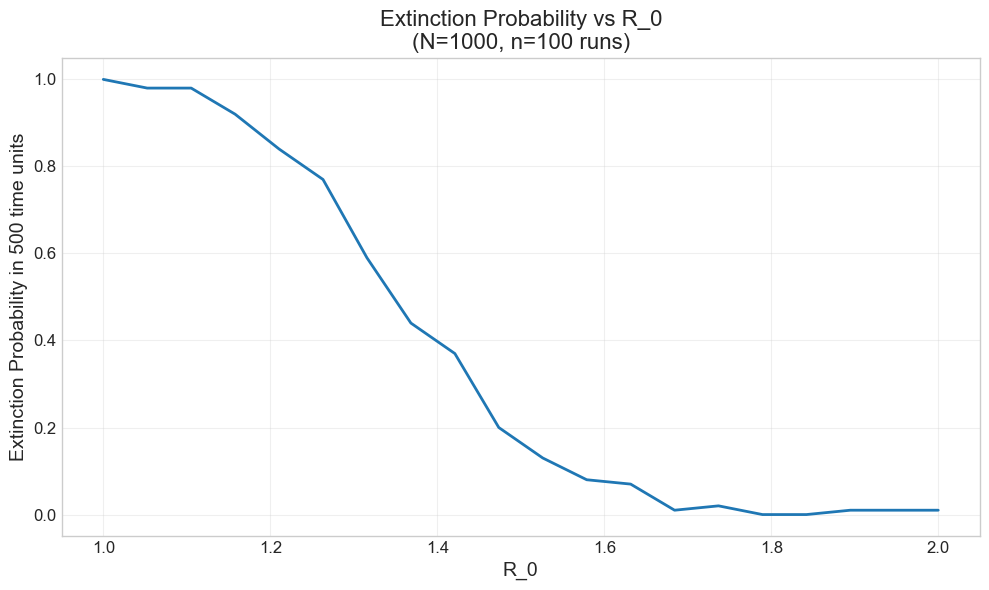

In [12]:
# We create a range of R_0 values (> 1) by varying beta keeping gamma and mu fixed
R0 = np.linspace(1, 2, 20)
gamma = 0.1
mu = 1 / 50
beta = [R0_i * (gamma + mu) for R0_i in R0]
N = 1000
X0 = np.round(0.05 * N)
Y0 = N - X0
Z0 = 0
seed0 = 42

# Create an experiment that runs the gillespie simulation for the differnt R_0 values each n times for statistical significance. Per simulation count the number of extinctions, and the time to extiction. Take the averages over the runs and plot them against the values of R_0

n_runs = 100  # Number of simulations per R0 value
tmax = 500.0  # Maximum simulation time

# Storage for results
mean_extinction_counts = []
mean_extinction_times = []


for idx, (R0_val, beta_val) in enumerate(zip(R0, beta)):
    extinctions = []
    extinction_times = []

    for run in range(n_runs):
        rng = np.random.default_rng(seed=seed0 + run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta_val, gamma, mu, N, X0, Y0, Z0, tmax=tmax, rng=rng
        )

        # Check if extinction occurred (Y reached 0 before tmax)
        extinction_idx = np.where(Y_hist == 0)[0]

        if len(extinction_idx) > 0:
            extinctions.append(1)
        else:
            extinctions.append(0)

    mean_extinction_counts.append(np.mean(extinctions))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(R0, mean_extinction_counts, linewidth=2)
ax.set_xlabel("R_0")
ax.set_ylabel("Extinction Probability in 500 time units")
ax.set_title(f"Extinction Probability vs R_0\n(N={N}, n={n_runs} runs)")
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

In [24]:
# We create a range of R_0 values (> 1) by varying beta keeping gamma and mu fixed
R0 = 1.3
gamma = 0.1
mu = 1 / 50
beta = R0 * (gamma + mu)
N = np.linspace(500, 6000, 20, dtype=int)
X0 = 50
Y0 = [N_val - X0 for N_val in N]
Z0 = 0
seed0 = 42

# Create an experiment that runs the gillespie simulation for the differnt R_0 values each n times for statistical significance. Per simulation count the number of extinctions, and the time to extiction. Take the averages over the runs and plot them against the values of R_0

n_runs = 100  # Number of simulations per R0 value
tmax = 500.0  # Maximum simulation time

# Storage for results
mean_extinction_counts = []
mean_extinction_times = []


for idx, (N_val, Y0_val) in enumerate(zip(N, Y0)):
    extinctions = []
    extinction_times = []

    for run in range(n_runs):
        rng = np.random.default_rng(seed=seed0 + run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N_val, X0, Y0_val, Z0, tmax=tmax, rng=rng
        )

        # Check if extinction occurred (Y reached 0 before tmax)
        extinction_idx = np.where(Y_hist == 0)[0]

        if len(extinction_idx) > 0:
            extinctions.append(1)
        else:
            extinctions.append(0)

    mean_extinction_counts.append(np.mean(extinctions))

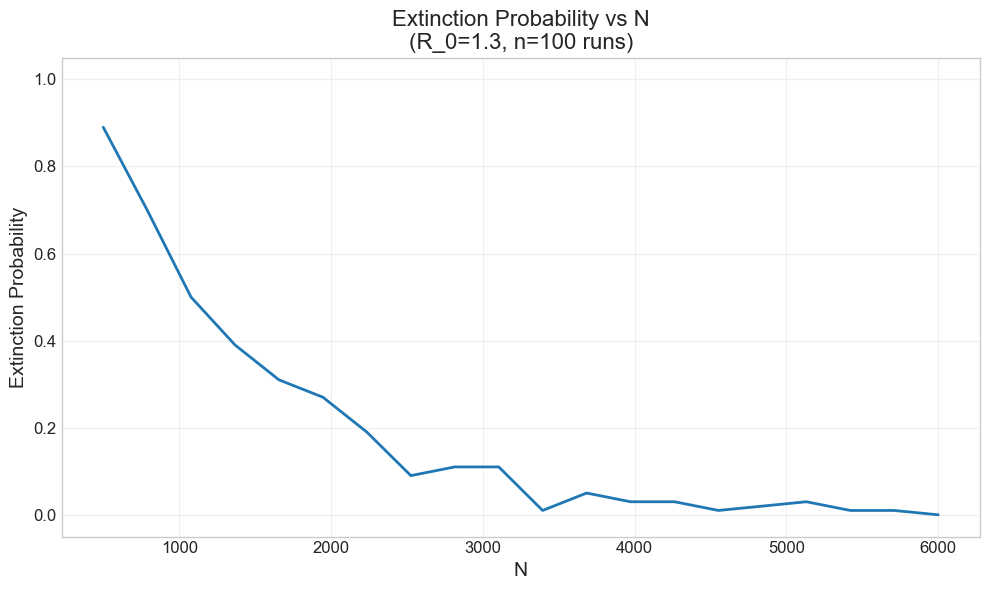

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(N, mean_extinction_counts, linewidth=2)
ax.set_xlabel("N")
ax.set_ylabel("Extinction Probability")
ax.set_title(f"Extinction Probability vs N\n(R_0={R0}, n={n_runs} runs)")
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

In [ ]:
from joblib import Parallel, delayed


def run_parameter_combination(
    R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed
):
    """
    Run simulations for a single (R0, N) parameter combination.
    Returns extinction probability for that combination.
    """
    extinctions = []
    Y0_val = N_val - X0
    Z0_val = 0

    for run in range(n_runs):
        # Use unique seed for each run
        seed = base_seed + run * 10000
        rng = np.random.default_rng(seed=seed)

        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta_val, gamma, mu, N_val, X0, Y0_val, Z0_val, tmax=tmax, rng=rng
        )

        # Check if extinction occurred (Y reached 0 before tmax)
        extinction_idx = np.where(Y_hist == 0)[0]

        if len(extinction_idx) > 0:
            extinctions.append(1)
        else:
            extinctions.append(0)

    return np.mean(extinctions)


# Create heatmap of extinction probabilities varying N and R0 - JOBLIB VERSION
gamma = 0.1
mu = 1 / 50
seed0 = 42

# Define parameter ranges
N_values = np.linspace(500, 5000, 10, dtype=int)  # Population sizes
R0_values = np.linspace(1, 2, 10)  # R0 values
beta_values = [R0_val * (gamma + mu) for R0_val in R0_values]

# Fixed parameters
X0 = 50  # Initial infected
tmax = 500.0  # Maximum simulation time
n_runs = 50  # Runs per parameter combination

# Prepare parameter combinations for joblib
param_combinations = []
combo_id = 0

for i, R0_val in enumerate(R0_values):
    beta_val = beta_values[i]
    for j, N_val in enumerate(N_values):
        # Create unique base seed for each parameter combination
        base_seed = seed0 + combo_id * 1000

        param_combinations.append(
            (i, j, R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed)
        )
        combo_id += 1

# Run multiprocessing with joblib

# Use joblib with all available cores and progress tracking
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_parameter_combination)(
        R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed
    )
    for i, j, R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed in param_combinations
)

# Reconstruct heatmap from results
extinction_heatmap = np.zeros((len(R0_values), len(N_values)))

for (i, j, *_), result in zip(param_combinations, results):
    extinction_heatmap[i, j] = result

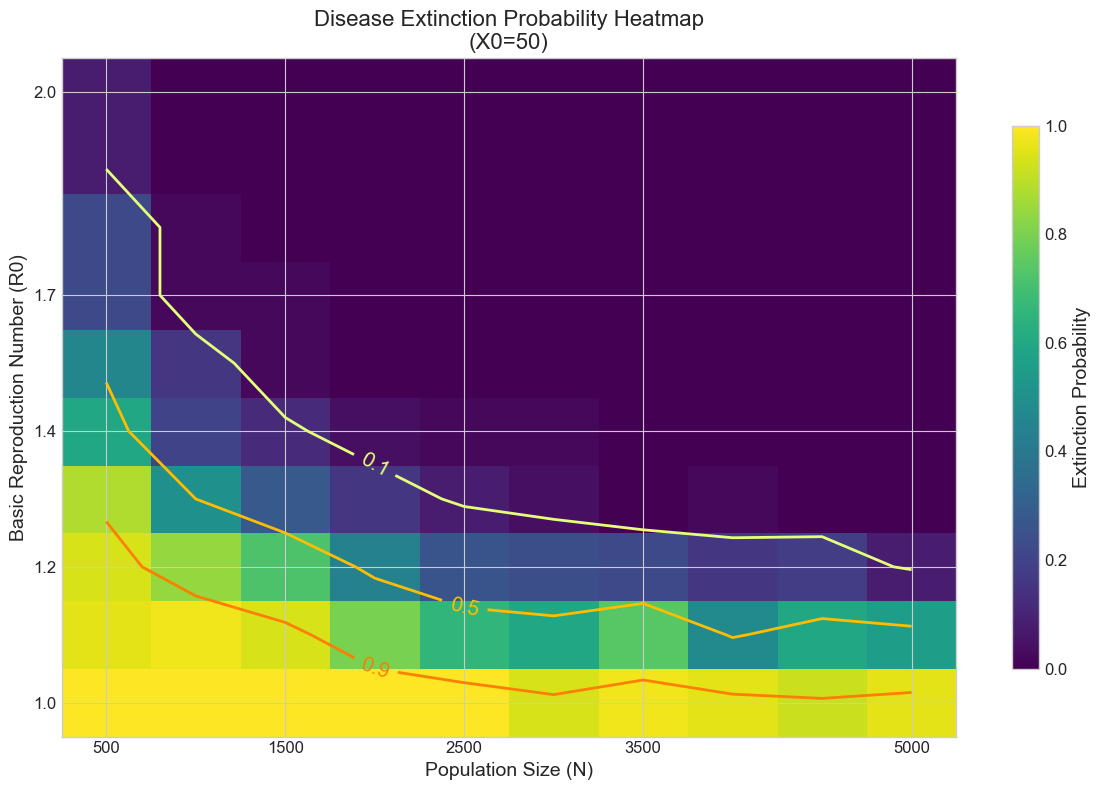

In [62]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(
    extinction_heatmap, cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=1
)

# Set ticks and labels
n_ticks = 5
r0_tick_indices = np.linspace(0, len(R0_values) - 1, n_ticks, dtype=int)
n_tick_indices = np.linspace(0, len(N_values) - 1, n_ticks, dtype=int)

ax.set_xticks(n_tick_indices)
ax.set_xticklabels([f"{N_values[i]:.0f}" for i in n_tick_indices])
ax.set_yticks(r0_tick_indices)
ax.set_yticklabels([f"{R0_values[i]:.1f}" for i in r0_tick_indices])

# Labels and title
ax.set_xlabel("Population Size (N)")
ax.set_ylabel("Basic Reproduction Number (R0)")
ax.set_title(f"Disease Extinction Probability Heatmap\n(X0={X0})")

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Extinction Probability")

# Add contour lines for specific extinction probabilities
contour_levels = [0.1, 0.5, 0.9]
contours = ax.contour(
    extinction_heatmap, levels=contour_levels, cmap="Wistia", linewidths=2
)
ax.clabel(contours, inline=True, fontsize=15, fmt="%.1f")

plt.tight_layout()
plt.show()

### Spatial Models

1. Generate Networks of Equivalent Form
    Goal: Create comparable networks by controllling for mean degree so differences in disease spread are due to network structure, not connectivy only.

    Plot:
    - Network stats comparison
    - Degree distributions
    - Log-log plot for Barabasi Albert for power-law distribution

2. Simulate SIR spread
    Goal: See how network structure affects disease dynamics

    Plot:
    - Parameter sweep results: Peak infection vs. R0 for each network type, heatmap of outcomes across beta, gamma, Final Epidemic Size Distribution
    - Time series comparison: SIR curves for some parameters on different networks
    - Initial Conditions Experiment: How different seeding strategies affect outcomes


In [123]:
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from __future__ import annotations
from typing import Dict, List, Tuple, Optional
import networkx as nx
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

In [244]:
class NetworkSimulator:
    def __init__(self, seed: int = 42):
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.network_types: List[str] = [
            "erdos_renyi",
            "barabasi_albert",
            "watts_strogatz",
        ]
        self.networks: Dict[str, List[nx.Graph]] = {}
        self.experiment_results: Optional[pd.DataFrame] = None

    @staticmethod
    def _set_mean_degree(n_nodes: int, target_k: float) -> Tuple[float, int, int]:
        if n_nodes <= 1:
            p = 0.0
        else:
            p = target_k / (n_nodes - 1)
        p = float(np.clip(p, 0.0, 1.0))

        m = int(round(target_k / 2.0))
        m = max(1, min(m, n_nodes - 1))

        k = int(round(target_k))
        k = min(k, n_nodes - 1)
        if k % 2:
            k = k - 1 if k > 1 else 2
        k = max(2, min(k, n_nodes - 2))
        return p, m, k
    
    
    def add_network(self, name: str, G: nx.Graph):
        """Add a custom network to the simulator."""
        if name not in self.networks:
            self.networks[name] = []
            if name not in self.network_types:
                self.network_types.append(name)
        self.networks[name].append(G)
        
        
    def load_sociopatterns(
        self,
        path: str,
        threshold: float = 0.0,
        giant_component: bool = True,
        relabel_to_int: bool = True
    )->nx.Graph:
        """Load the transmission_network.csv file"""
        
        df = pd.read_csv(path, sep=';', header=None)
        
        labels_row = df.iloc[0, 1:].astype(int).tolist()
        labels_col = df.iloc[1:, 0].astype(int).tolist()
        if labels_row != labels_col:
            raise ValueError("Row/column labels mismatch in sociopatterns file.")
        
        A = df.iloc[1:, 1:].to_numpy(dtype=float)
        
        
        # Build graph, undirected & unweighted
        
        G = nx.Graph()
        G.add_nodes_from(labels_row)
        n = A.shape[0]
        
        for i in range(n):
            for j in range(i + 1, n):
                if A[i, j] > threshold:
                    G.add_edge(labels_row[i], labels_row[j])
                    
        if giant_component and G.number_of_nodes() > 0 and not nx.is_connected(G):
             G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
             
        
        # relabel to integers 0..N-1

        if relabel_to_int:
            nx.set_node_attributes(G, {old: {"orig_id": old} for old in G.nodes()})
            mapping = {old: i for i, old in enumerate(G.nodes())}
            G = nx.relabel_nodes(G, mapping, copy=True)
                    
        # register
        self.add_network("sociopatterns", G)
        
        # Sanity check
        degs = [d for _, d in G.degree()]
        print(f"[Sociopatterns] N={G.number_of_nodes()}, L={G.number_of_edges()}, ⟨k⟩={np.mean(degs):.2f}")
        return G


    # Network generation
    def generate_networks(
        self,
        n_nodes: int = 100,
        n_instances: int = 5,
        target_k: float = 6.0,
        ws_p: float = 0.3,
    ) -> Dict[str, List[nx.Graph]]:
        p, m, k = self._set_mean_degree(n_nodes, target_k)
        print(
            f"[Generate] N={n_nodes}, instances={n_instances}, target ⟨k⟩={target_k:.2f}"
        )
        print(f"  ER: p={p:.4f}   BA: m={m}   WS: k={k}, p_rewire={ws_p}")

        self.networks = {t: [] for t in self.network_types}
        for i in range(n_instances):
            base = self.seed + i
            self.networks["erdos_renyi"].append(
                nx.erdos_renyi_graph(n_nodes, p, seed=base)
            )
            self.networks["barabasi_albert"].append(
                nx.barabasi_albert_graph(n_nodes, m, seed=base)
            )
            self.networks["watts_strogatz"].append(
                nx.watts_strogatz_graph(n_nodes, k, ws_p, seed=base)
            )

        for t in self.network_types:
            means = []
            for G in self.networks[t]:
                degs = [d for _, d in G.degree()]
                means.append(np.mean(degs))
            print(
                f"  {t.replace('_',' ').title():>16}: realized ⟨k⟩ = {np.mean(means):.2f} ± {np.std(means):.2f}"
            )
        return self.networks

    # Network metrics (structure + epidemic-relevant)

    def compute_network_stats(self, G: nx.Graph) -> Dict[str, float]:
        """Structure metrics + epidemic-relevant degree moments (⟨k⟩, ⟨k²⟩, τc)."""
        stats: Dict[str, float] = {}
        n = G.number_of_nodes()
        m = G.number_of_edges()
        stats["n_nodes"] = n
        stats["n_edges"] = m
        stats["density"] = nx.density(G)

        # Degrees & moments
        degs = (
            np.fromiter((d for _, d in G.degree()), dtype=float, count=n)
            if n
            else np.array([])
        )
        if n > 0 and degs.size > 0:
            k1 = float(degs.mean())
            k2 = float((degs**2).mean())
            stats["avg_degree"] = k1
            stats["std_degree"] = float(degs.std())
            stats["min_degree"] = float(degs.min())
            stats["max_degree"] = float(degs.max())
            stats["second_moment_k2"] = k2
            stats["degree_heterogeneity"] = float(degs.var() / k1) if k1 > 0 else np.nan
            stats["tau_c_mean_over_second"] = (
                (k1 / k2) if k2 > 0 else np.nan
            )  # threshold proxy
        else:
            stats.update(
                {
                    "avg_degree": 0.0,
                    "std_degree": 0.0,
                    "min_degree": 0.0,
                    "max_degree": 0.0,
                    "second_moment_k2": 0.0,
                    "degree_heterogeneity": np.nan,
                    "tau_c_mean_over_second": np.nan,
                }
            )

        if n == 0:
            stats.update(
                {
                    "n_components": 0,
                    "lcc_frac": 0.0,
                    "avg_path_length": np.nan,
                    "diameter": np.nan,
                    "avg_clustering": np.nan,
                    "transitivity": np.nan,
                    "second_moment_k2": 0.0,
                    "degree_heterogeneity": np.nan,
                    "tau_c_mean_over_second": np.nan,
                    "avg_betweenness": np.nan,
                }
            )
            return stats

        # Components/LCC
        if nx.is_connected(G):
            H = G
            stats["n_components"] = 1
            stats["lcc_frac"] = 1.0
        else:
            components = sorted(nx.connected_components(G), key=len, reverse=True)
            H = G.subgraph(components[0]).copy()
            stats["n_components"] = nx.number_connected_components(G)
            stats["lcc_frac"] = len(H) / n

        # Distances on LCC
        if H.number_of_nodes() > 1:
            stats["avg_path_length"] = nx.average_shortest_path_length(H)
            stats["diameter"] = nx.diameter(H)
        else:
            stats["avg_path_length"] = 0.0
            stats["diameter"] = 0.0

        # Clustering (local mean) & global transitivity
        stats["avg_clustering"] = nx.average_clustering(G) if n > 0 else np.nan
        stats["transitivity"] = nx.transitivity(G) if n > 0 else np.nan

        # Approximate betweenness 
        k_sample = min(100, n)
        bet = nx.betweenness_centrality(G, k=k_sample, seed=self.seed)
        stats["avg_betweenness"] = float(np.mean(list(bet.values()))) if bet else 0.0
        return stats


    # Epidemic metrics (computed from NDlib trends)

    def compute_epidemic_metrics(self, result: Dict) -> Dict[str, float]:
        """
        Standard epidemic metrics from a run_sir_simulation result.
        - attack_rate: final recovered / N
        - epidemic_duration: last time any I(t) > 0 (iterations)
        - exponential_growth_rate: slope of log(I+1) in early phase
        """
        N = result["n_nodes"]
        trends = result["trends"][0]["trends"]["node_count"]  # NDlib structure
        I_curve = np.asarray(trends[1], dtype=float)  # 1 = Infected
        R_curve = np.asarray(trends[2], dtype=float)  # 2 = Removed

        attack_rate = float(R_curve[-1] / N) if N > 0 else np.nan

        nz = np.nonzero(I_curve)[0]
        epidemic_duration = int(nz[-1] + 1) if nz.size > 0 else 0

        t_peak = int(result["time_to_peak"])
        cutoff = max(3, int(0.3 * t_peak))  # up to ~30% of peak time
        early = I_curve[:cutoff]
        if early.size >= 3:
            logI = np.log(early + 1.0)  # avoid log(0)
            x = np.arange(len(logI))
            slope, _ = np.polyfit(x, logI, 1)
            growth_rate = float(slope)
        else:
            growth_rate = np.nan

        return {
            "attack_rate": attack_rate,
            "epidemic_duration": epidemic_duration,
            "exponential_growth_rate": growth_rate,
        }

    # Merge network + epidemic metrics in one dict

    def compute_all_metrics(self, G: nx.Graph, sim_result: Dict) -> Dict[str, float]:
        """
        One-stop metrics aggregator:
        - Network stats (structure + ⟨k⟩, ⟨k²⟩, τc)
        - Epidemic summaries (peak, timing, final size, attack rate, duration, growth rate)
        - Basic R0 (β/γ)
        """
        net = self.compute_network_stats(G)
        epi = self.compute_epidemic_metrics(sim_result)
        merged = dict(net)
        merged.update(
            {
                "beta": sim_result["beta"],
                "gamma": sim_result["gamma"],
                "R0_naive": (
                    (sim_result["beta"] / sim_result["gamma"])
                    if sim_result["gamma"] > 0
                    else np.inf
                ),
                "peak_infected": sim_result["peak_infected"],
                "time_to_peak": sim_result["time_to_peak"],
                "final_recovered": sim_result["final_recovered"],
                "peak_frac": sim_result["peak_frac"],
                "final_size_frac": sim_result["final_size_frac"],
            }
        )
        merged.update(epi)
        return merged


    # SIR simulations

    def run_sir_simulation(
        self,
        G: nx.Graph,
        beta: float = 0.5,
        gamma: float = 0.1,
        fraction_infected: float = 0.05,
        iterations: int = 200,
        seed: Optional[int] = None,
    ) -> Dict[str, object]:
        if seed is not None:
            np.random.seed(seed)

        model = ep.SIRModel(G)
        config = mc.Configuration()
        config.add_model_parameter("beta", float(beta))
        config.add_model_parameter("gamma", float(gamma))
        config.add_model_parameter("fraction_infected", float(fraction_infected))
        model.set_initial_status(config)

        iters = model.iteration_bunch(iterations)
        trends = model.build_trends(iters)

        s2i = getattr(
            model, "available_statuses", {"Susceptible": 0, "Infected": 1, "Removed": 2}
        )
        I_idx = s2i["Infected"]
        R_idx = s2i["Removed"]

        node_count = trends[0]["trends"]["node_count"]
        infected = np.asarray(node_count[I_idx], dtype=float)
        removed = np.asarray(node_count[R_idx], dtype=float)

        peak_infected = float(infected.max())
        time_to_peak = int(infected.argmax())
        final_recovered = float(removed[-1])
        N = G.number_of_nodes()

        return {
            "trends": trends,
            "iterations": iters,
            "beta": beta,
            "gamma": gamma,
            "fraction_infected": fraction_infected,
            "n_nodes": N,
            "peak_infected": peak_infected,
            "time_to_peak": time_to_peak,
            "final_recovered": final_recovered,
            "peak_frac": peak_infected / N if N else np.nan,
            "final_size_frac": final_recovered / N if N else np.nan,
        }


    # Sweeps

    def experiment_parameter_sweep(
        self,
        n_repetitions: int = 5,
        beta_values: Optional[List[float]] = None,
        gamma_values: Optional[List[float]] = None,
    ) -> pd.DataFrame:
        if not self.networks:
            raise RuntimeError("No networks stored")

        if beta_values is None:
            beta_values = [0.05, 0.1, 0.2]
        if gamma_values is None:
            gamma_values = [0.02, 0.05, 0.1]

        rows = []
        for network_type in self.network_types:
            nets = self.networks[network_type]
            for beta in beta_values:
                for gamma in gamma_values: 
                    for r in range(n_repetitions):
                        idx = int(self.rng.integers(0, len(nets)))
                        G = nets[idx]
                        res = self.run_sir_simulation(
                            G,
                            beta=beta,
                            gamma=gamma,
                            fraction_infected=0.05,
                            iterations=200,
                            seed=self.seed + r,
                        )
                        allm = self.compute_all_metrics(G, res)
                        allm.update(
                            {
                                "network_type": network_type,
                                "rep": r,
                                "net_idx": idx,
                            }
                        )
                        rows.append(allm)
        self.experiment_results = pd.DataFrame(rows)
        return self.experiment_results

    # Seeding strategies (random/high/low degree)

    def experiment_initial_conditions(
        self,
        beta: float = 0.5,
        gamma: float = 0.1,
        iterations: int = 200,
        fractions: List[float] = [0.01, 0.05, 0.1],
        repetitions: int = 5,
    ) -> pd.DataFrame:
        if not self.networks:
            raise RuntimeError("No networks stored")

        strategies = {
            "random": self._infect_random,
            "high_degree": self._infect_high_degree,
            "low_degree": self._infect_low_degree,
        }

        rows = []
        for net_type in self.network_types:
            for frac in fractions:
                for strat_name, strat_fn in strategies.items():
                    for rep in range(repetitions):
                        G = self.networks[net_type][rep % len(self.networks[net_type])]

                        model = ep.SIRModel(G)
                        cfg = mc.Configuration()
                        cfg.add_model_parameter("beta", float(beta))
                        cfg.add_model_parameter("gamma", float(gamma))

                        infected0 = strat_fn(G, frac)
                        for u in G.nodes():
                            cfg.add_node_configuration(
                                "status", u, 1 if u in infected0 else 0
                            )

                        model.set_initial_status(cfg)
                        its = model.iteration_bunch(iterations)
                        trends = model.build_trends(its)

                        s2i = getattr(
                            model,
                            "available_statuses",
                            {"Susceptible": 0, "Infected": 1, "Removed": 2},
                        )
                        I_idx, R_idx = s2i["Infected"], s2i["Removed"]
                        node_count = trends[0]["trends"]["node_count"]
                        infected = np.asarray(node_count[I_idx], dtype=float)
                        removed = np.asarray(node_count[R_idx], dtype=float)

                        peak = float(infected.max())
                        tpeak = int(infected.argmax())
                        finalR = float(removed[-1])
                        N = G.number_of_nodes()

                        res = {
                            "trends": trends,
                            "n_nodes": N,
                            "beta": beta,
                            "gamma": gamma,
                            "time_to_peak": tpeak,
                            "peak_infected": peak,
                            "final_recovered": finalR,
                            "peak_frac": peak / N,
                            "final_size_frac": finalR / N,
                        }
                        allm = self.compute_all_metrics(G, res)
                        allm.update(
                            {
                                "network_type": net_type,
                                "strategy": strat_name,
                                "seed_fraction": frac,
                                "rep": rep,
                            }
                        )
                        rows.append(allm)

        return pd.DataFrame(rows)

    # Seeding helpers

    def _infect_random(self, G: nx.Graph, fraction: float) -> set:
        n = G.number_of_nodes()
        k = max(1, int(round(fraction * n)))
        nodes = np.array(G.nodes())
        return set(self.rng.choice(nodes, size=k, replace=False))

    def _infect_high_degree(self, G: nx.Graph, fraction: float) -> set:
        n = G.number_of_nodes()
        k = max(1, int(round(fraction * n)))
        sorted_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)
        return set([node for node, _ in sorted_nodes[:k]])

    def _infect_low_degree(self, G: nx.Graph, fraction: float) -> set:
        n = G.number_of_nodes()
        k = max(1, int(round(fraction * n)))
        return set([u for u, _d in sorted(G.degree(), key=lambda x: x[1])[:k]])

In [134]:
def test_all(
    network_n=400, instances=5, target_k=8, ws_p=0.15, beta=0.10, gamma=0.05, iters=220
):
    sim = NetworkSimulator(seed=123)

    # Build networks
    sim.generate_networks(
        n_nodes=network_n, n_instances=instances, target_k=target_k, ws_p=ws_p
    )

    # Sumamry per network type (averaged across instances)
    rows = []
    for nt in sim.network_types:
        stats = [sim.compute_network_stats(G) for G in sim.networks[nt]]
        df = pd.DataFrame(stats)
        rows.append(
            {
                "network_type": nt,
                "N_mean±sd": f"{df['n_nodes'].mean():.0f}±{df['n_nodes'].std():.0f}",
                "⟨k⟩ mean±sd": f"{df['avg_degree'].mean():.2f}±{df['avg_degree'].std():.2f}",
                "std(k) mean": f"{df['std_degree'].mean():.2f}",
                "clustering mean": f"{df['avg_clustering'].mean():.3f}",
                "LCC frac mean": f"{df['lcc_frac'].mean():.3f}",
                "τc=<k>/<k²> mean": f"{df['tau_c_mean_over_second'].mean():.4f}",
                "APL(LCC) mean": f"{df['avg_path_length'].mean():.2f}",
            }
        )

    print("\n[Sructure] Averaged metrics per network type")
    print(pd.DataFrame(rows).to_string(index=False))

    # SIR simulation per network, with  metrics
    epi_rows = []
    for nt in sim.network_types:
        G = sim.networks[nt][0]
        res = sim.run_sir_simulation(
            G, beta=beta, gamma=gamma, fraction_infected=0.1, iterations=iters, seed=123
        )
        allm = sim.compute_all_metrics(G, res)
        epi_rows.append(
            {
                "network_type": nt,
                "R0=β/γ": f"{allm['R0_naive']:.2f}",
                "peak_frac": f"{allm['peak_frac']:.3f}",
                "time_to_peak": int(allm["time_to_peak"]),
                "final_size_frac": f"{allm['final_size_frac']:.3f}",
                "attack_rate": f"{allm['attack_rate']:.3f}",
                "duration": int(allm["epidemic_duration"]),
                "growth_rate(early)": f"{allm['exponential_growth_rate']:.3f}",
            }
        )
    print("\n[ONE-RUN SIR] Key outcomes (first instance of each type)")
    print(pd.DataFrame(epi_rows).to_string(index=False))

    # Minimal parameter sweep
    betas = [0.05, 0.08, 0.12, 0.18]
    gammas = [0.03, 0.05, 0.08]
    df = sim.experiment_parameter_sweep(
        n_repetitions=3, beta_values=betas, gamma_values=gammas
    )

    def tidy(group):
        return pd.Series(
            {
                "peak_frac_mean": group["peak_frac"].mean(),
                "final_size_mean": group["final_size_frac"].mean(),
                "time_to_peak_mean": group["time_to_peak"].mean(),
            }
        )

    summary = df.groupby(["network_type", "beta", "gamma"]).apply(tidy).reset_index()

    print("\n[SWEEP] Summary (means over reps/instances)")
    # Only show a few rows so it stays readable; comment out .head if you want all.
    print(summary.round(3).head(12).to_string(index=False))

    # Return objects if you want to inspect/plot further
    return sim, summary, df

In [213]:
sim, summary, df = test_all()

[Generate] N=400, instances=5, target ⟨k⟩=8.00
  ER: p=0.0201   BA: m=4   WS: k=8, p_rewire=0.15
       Erdos Renyi: realized ⟨k⟩ = 8.06 ± 0.09
   Barabasi Albert: realized ⟨k⟩ = 7.92 ± 0.00
    Watts Strogatz: realized ⟨k⟩ = 8.00 ± 0.00

[Sructure] Averaged metrics per network type
   network_type N_mean±sd ⟨k⟩ mean±sd std(k) mean clustering mean LCC frac mean τc=<k>/<k²> mean APL(LCC) mean
    erdos_renyi     400±0   8.06±0.10        2.83           0.022         0.999           0.1104          3.10
barabasi_albert     400±0   7.92±0.00        7.51           0.064         1.000           0.0665          2.88
 watts_strogatz     400±0   8.00±0.00        1.05           0.399         1.000           0.1229          3.90

[ONE-RUN SIR] Key outcomes (first instance of each type)
   network_type R0=β/γ peak_frac  time_to_peak final_size_frac attack_rate  duration growth_rate(early)
    erdos_renyi   2.00     0.715            11           0.998       0.998       118              0.424
baraba

In [214]:
summary_sorted = summary.sort_values(["beta", "gamma", "network_type"]).round(3)
print(summary_sorted.to_string(index=False))
""

   network_type  beta  gamma  peak_frac_mean  final_size_mean  time_to_peak_mean
barabasi_albert  0.05   0.03           0.692            0.993             17.667
    erdos_renyi  0.05   0.03           0.703            0.992             17.667
 watts_strogatz  0.05   0.03           0.658            0.997             20.667
barabasi_albert  0.05   0.05           0.589            0.972             13.333
    erdos_renyi  0.05   0.05           0.601            0.985             15.000
 watts_strogatz  0.05   0.05           0.532            0.991             20.667
barabasi_albert  0.05   0.08           0.438            0.918             13.333
    erdos_renyi  0.05   0.08           0.434            0.952             17.667
 watts_strogatz  0.05   0.08           0.386            0.974             23.000
barabasi_albert  0.08   0.03           0.758            0.995             12.667
    erdos_renyi  0.08   0.03           0.758            0.996             13.000
 watts_strogatz  0.08   0.03

''

In [225]:
# Plotting class


class Plotter:

    def __init__(self, sim, pretty_style=True):
        self.sim = sim
        if pretty_style:
            plt.rcParams.update({
                "figure.dpi": 110,
                "axes.grid": True, "grid.alpha": 0.3,
                "axes.spines.top": False, "axes.spines.right": False
            })

    def structure_overview(self):
        """
        Summary table (mean ± std) + bar plots + degree histograms for ER/BA/WS.
        Requires sim.compute_network_stats to include:
        avg_degree, std_degree, density, avg_path_length, avg_clustering,
        transitivity, tau_c_mean_over_second (⟨k⟩/⟨k²⟩)
        """
        sim = self.sim
        if not sim.networks:
            raise RuntimeError("No networks stored")

        rows = []
        for nt in sim.network_types:
            for G in sim.networks[nt]:
                s = sim.compute_network_stats(G)
                s["network_type"] = nt
                rows.append(s)
        df = pd.DataFrame(rows)

        cols = [
            ("avg_degree", "⟨k⟩"),
            ("std_degree", "std(k)"),
            ("density", "density"),
            ("avg_path_length", "APL(LCC)"),
            ("avg_clustering", "clustering"),
            ("transitivity", "transitivity"),
            ("tau_c_mean_over_second", "τc=⟨k⟩/⟨k²⟩"),
        ]

        agg = df.groupby("network_type")[[c for c, _ in cols]].agg(["mean", "std"])

        pretty = pd.DataFrame(index=agg.index)
        for c, label in cols:
            m = agg[(c, "mean")]
            sd = agg[(c, "std")]
            if c in ("avg_degree", "std_degree", "avg_path_length"):
                fmt = lambda x: f"{x:.2f}"
            elif c in (
                "density",
                "avg_clustering",
                "transitivity",
                "tau_c_mean_over_second",
            ):
                fmt = lambda x: f"{x:.4f}"
            else:
                fmt = lambda x: f"{x:.3f}"
            pretty[label] = [f"{fmt(mi)}±{fmt(si)}" for mi, si in zip(m, sd)]
        pretty.index = [nt.replace("_", " ").title() for nt in pretty.index]

        print("\nNetwork Structure: Means ± SD across instances")
        print(pretty.to_string())

        #  Bar plots (mean ± sd)
        metrics = [
            ("avg_degree", "Average Degree"),
            ("avg_path_length", "Average Path Length (LCC)"),
            ("std_degree", "Degree Std Dev"),
            ("density", "Density"),
            ("avg_clustering", "Average Clustering"),
            ("transitivity", "Transitivity"),
        ]
        n_cols = 2
        n_rows = int(np.ceil(len(metrics) / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        colors = {
            "erdos_renyi": "#8ecae6",
            "barabasi_albert": "#bde0fe",
            "watts_strogatz": "#ffc8dd",
        }

        for ax, (key, label) in zip(axes, metrics):
            g = df.groupby("network_type")[key].agg(["mean", "std"])
            x = np.arange(len(g))
            ax.bar(
                x,
                g["mean"].values,
                yerr=g["std"].values,
                color=[colors[t] for t in g.index],
                alpha=0.85,
                capsize=5,
            )
            ax.set_xticks(x)
            ax.set_xticklabels([t.replace("_", " ").title() for t in g.index])
            ax.set_ylabel(label)
            ax.set_title(label)
            ax.grid(True, alpha=0.3, axis="y")

        for j in range(len(metrics), len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle("Network Structure Overview (mean ± std)", fontweight="bold")
        plt.tight_layout()
        plt.show()

        # Degree distributions

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        for ax, t in zip(axes, sim.network_types):
            degrees = []
            for G in sim.networks[t]:
                degrees.extend([d for _, d in G.degree()])
            ax.hist(degrees, bins=30, edgecolor="black", alpha=0.75)
            ax.set_title(t.replace("_", " ").title())
            ax.set_xlabel("Degree")
            ax.set_ylabel("Frequency")
            ax.grid(True, alpha=0.3)

            # BA log–log inset for tail
            if t == "barabasi_albert" and len(degrees) > 0:
                counts = np.bincount(degrees)
                k = np.arange(len(counts))
                mask = counts > 0
                inset = ax.inset_axes([0.55, 0.55, 0.4, 0.4])
                inset.loglog(k[mask], counts[mask], "o", ms=3)
                inset.set_title("Log–log", fontsize=8)
                inset.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # SIR Comparison

    def sir_comparison(
        self, beta=0.1, gamma=0.05, fraction_infected=0.02, iterations=220
    ):
        """
        One SIR run per network type (1st instance). Plots S, I, R counts over time with peak marker.
        """
        sim = self.sim
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for idx, net_type in enumerate(sim.network_types):
            G = sim.networks[net_type][0]
            res = sim.run_sir_simulation(
                G,
                beta=beta,
                gamma=gamma,
                fraction_infected=fraction_infected,
                iterations=iterations,
                seed=sim.seed,
            )
            trends = res["trends"][0]["trends"]["node_count"]
            ax = axes[idx]
            ax.plot(trends[0], "b-", label="S", linewidth=2)
            ax.plot(trends[1], "r-", label="I", linewidth=2)
            ax.plot(trends[2], "g-", label="R", linewidth=2)
            ax.set_title(net_type.replace("_", " ").title())
            ax.set_xlabel("Time")
            ax.set_ylabel("Count")
            ax.legend()
            ax.grid(True, alpha=0.3)
            peak_i = max(trends[1])
            peak_t = trends[1].index(peak_i)
            ax.plot(peak_t, peak_i, "ro", markersize=7)
            ax.annotate(
                f"Peak: {peak_i}",
                xy=(peak_t, peak_i),
                xytext=(peak_t + 5, peak_i + 5),
                arrowprops=dict(arrowstyle="->", color="red", alpha=0.5),
            )
        fig.suptitle(f"SIR Comparison (β={beta}, γ={gamma}, R₀={beta/gamma:.2f})")
        fig.tight_layout()
        plt.show()

    def epidemic_snapshot(
        self,
        network_type: str,
        instance: int,
        beta: float,
        gamma: float,
        fraction_infected: float = 0.02,
        iterations: int = 220,
        t: int = 20,
        layout: str = "spring",
    ):
        """
        Simulate once on the selected graph and draw the network at time t,
        coloring nodes by S (blue), I (red), R (green).
        """
        sim = self.sim
        color_map = {0: "#1f77b4", 1: "#d62728", 2: "#2ca02c"}  # S, I, R
        G = sim.networks[network_type][instance]
        res = sim.run_sir_simulation(
            G,
            beta=beta,
            gamma=gamma,
            fraction_infected=fraction_infected,
            iterations=iterations,
            seed=sim.seed,
        )
        iters = res["iterations"]
        t = max(0, min(t, len(iters) - 1))
        status_dict = iters[t]["status"]  # {node: state_code}
        colors = [color_map[status_dict.get(n, 0)] for n in G.nodes()]

        if layout == "spring":
            pos = nx.spring_layout(G, seed=sim.seed)
        elif layout == "kamada_kawai":
            pos = nx.kamada_kawai_layout(G)
        elif layout == "circular":
            pos = nx.circular_layout(G)
        else:
            pos = nx.spring_layout(G, seed=sim.seed)

        plt.figure(figsize=(6.5, 6.0))
        nx.draw_networkx_nodes(
            G, pos, node_color=colors, node_size=30, linewidths=0.2, edgecolors="k"
        )
        nx.draw_networkx_edges(G, pos, alpha=0.25, width=0.7)
        plt.title(
            f"{network_type.replace('_',' ').title()} snapshot @ t={t} (β={beta}, γ={gamma})"
        )
        plt.axis("off")
        plt.show()

    # Parameter sweep plots

    def parameter_sweep(self, df: pd.DataFrame):
        """Sumamry using experiment_results:"""

        if df is None or df.empty:
            print("No experiment results.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Peak vs R0
        ax = axes[0, 0]
        for net_type in self.sim.network_types:
            data = df[df["network_type"] == net_type]
            grouped = data.groupby("R0_naive").agg({"peak_frac": ["mean", "std"]})
            x = grouped.index
            y = grouped["peak_frac"]["mean"]
            yerr = grouped["peak_frac"]["std"]
            ax.errorbar(x, y, yerr=yerr, marker="o", label=net_type, capsize=5)
        ax.set_xlabel("R0 = β/γ")
        ax.set_ylabel("Peak Infected Fraction")
        ax.set_title("Peak Infection vs R0")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Time to peak box
        ax = axes[0, 1]
        data_box = [
            df[df["network_type"] == t]["time_to_peak"].values
            for t in self.sim.network_types
        ]
        ax.boxplot(
            data_box,
            labels=[t.replace("_", " ").title() for t in self.sim.network_types],
        )
        ax.set_ylabel("Time to Peak")
        ax.set_title("Speed of Epidemic Peak")
        ax.grid(True, alpha=0.3)

        # Heatmap of peak
        ax = axes[1, 0]
        pivot = df.pivot_table(
            values="peak_frac", index="gamma", columns="beta", aggfunc="mean"
        )
        im = ax.imshow(
            pivot,
            cmap="YlOrRd",
            aspect="auto",
            extent=[
                pivot.columns.min(),
                pivot.columns.max(),
                pivot.index.min(),
                pivot.index.max(),
            ],
            origin="lower",
        )
        ax.set_xlabel("β")
        ax.set_ylabel("γ")
        ax.set_title("Peak Infection Fraction Heatmap")
        plt.colorbar(im, ax=ax)

        # Final size vs R0
        ax = axes[1, 1]
        for net_type in self.sim.network_types:
            data = df[df["network_type"] == net_type]
            ax.scatter(
                data["R0_naive"],
                data["final_size_frac"],
                alpha=0.5,
                label=net_type,
                s=20,
            )
        ax.axvline(x=1, color="red", linestyle="--", alpha=0.5)
        ax.set_xlabel("R0 = β/γ")
        ax.set_ylabel("Final Epidemic Size")
        ax.set_title("R0 vs Final Size")
        ax.legend()
        ax.grid(True, alpha=0.3)

        fig.tight_layout()
        plt.show()

    # Intiial Condition Effects

    def fraction_effects(self, df_ic, metric="peak_frac", show_strategies=True):
        """
        Summarize how outcomes change with initial infected fraction.
        Default shows separate lines per strategy within each network type.
        Set show_strategies=False to average over strategies.
        """
        if df_ic is None or df_ic.empty:
            print("No data to plot")
            return

        frac_col = (
            "fraction"
            if "fraction" in df_ic.columns
            else ("seed_fraction" if "seed_fraction" in df_ic.columns else None)
        )
        if frac_col is None:
            raise KeyError("Expected a 'fraction' or 'seed_fraction' column in df_ic.")

        if metric not in df_ic.columns:
            raise KeyError(
                f"Metric '{metric}' not found in df_ic. Available: {list(df_ic.columns)}"
            )

        df_ic = df_ic.copy()
        df_ic[frac_col] = pd.to_numeric(df_ic[frac_col], errors="coerce")

        if not show_strategies:
            g = (
                df_ic.groupby(["network_type", frac_col])[metric]
                .agg(["mean", "std"])
                .reset_index()
            )
            fig, ax = plt.subplots(figsize=(7.5, 5))
            for nt, sub in g.groupby("network_type"):
                sub = sub.sort_values(frac_col)
                ax.errorbar(
                    sub[frac_col],
                    sub["mean"],
                    yerr=sub["std"],
                    marker="o",
                    capsize=4,
                    label=nt,
                )
            ax.set_xlabel("Initial infected fraction")
            ax.set_ylabel(metric.replace("_", " ").title())
            ax.set_title(
                f'{metric.replace("_"," ").title()} vs Initial Fraction (averaged over strategies)'
            )
            ax.grid(True, alpha=0.3)
            ax.legend()
            plt.tight_layout()
            plt.show()
        else:
            nts = sorted(df_ic["network_type"].unique())
            fig, axes = plt.subplots(
                1, len(nts), figsize=(5 * len(nts), 4), sharey=True
            )
            if len(nts) == 1:
                axes = [axes]
            for ax, nt in zip(axes, nts):
                sub = df_ic[df_ic["network_type"] == nt]
                g = (
                    sub.groupby(["strategy", frac_col])[metric]
                    .agg(["mean", "std"])
                    .reset_index()
                )
                for strat, sub2 in g.groupby("strategy"):
                    sub2 = sub2.sort_values(frac_col)
                    ax.errorbar(
                        sub2[frac_col],
                        sub2["mean"],
                        yerr=sub2["std"],
                        marker="o",
                        capsize=4,
                        label=strat.replace("_", " "),
                    )
                ax.set_title(nt.replace("_", " ").title())
                ax.set_xlabel("Initial infected fraction")
                ax.grid(True, alpha=0.3)
            axes[0].set_ylabel(metric.replace("_", " ").title())
            handles, labels = axes[-1].get_legend_handles_labels()
            fig.legend(handles, labels, loc="upper center", ncol=3)
            plt.show()

In [226]:
sim = NetworkSimulator(seed=42)
sim.generate_networks(
    n_nodes=400,
    n_instances=5,
    target_k=5.0,
    ws_p=0.15,            # small-world shortcuts
);

[Generate] N=400, instances=5, target ⟨k⟩=5.00
  ER: p=0.0125   BA: m=2   WS: k=4, p_rewire=0.15
       Erdos Renyi: realized ⟨k⟩ = 4.92 ± 0.10
   Barabasi Albert: realized ⟨k⟩ = 3.98 ± 0.00
    Watts Strogatz: realized ⟨k⟩ = 4.00 ± 0.00



Network Structure: Means ± SD across instances
                       ⟨k⟩     std(k)        density   APL(LCC)     clustering   transitivity    τc=⟨k⟩/⟨k²⟩
Barabasi Albert  3.98±0.00  4.86±0.28  0.0100±0.0000  3.64±0.05  0.0595±0.0119  0.0211±0.0024  0.1012±0.0067
Erdos Renyi      4.92±0.11  2.20±0.10  0.0123±0.0003  3.92±0.05  0.0137±0.0033  0.0142±0.0027  0.1695±0.0033
Watts Strogatz   4.00±0.00  0.75±0.04  0.0100±0.0000  6.35±0.23  0.3124±0.0213  0.2901±0.0223  0.2415±0.0009


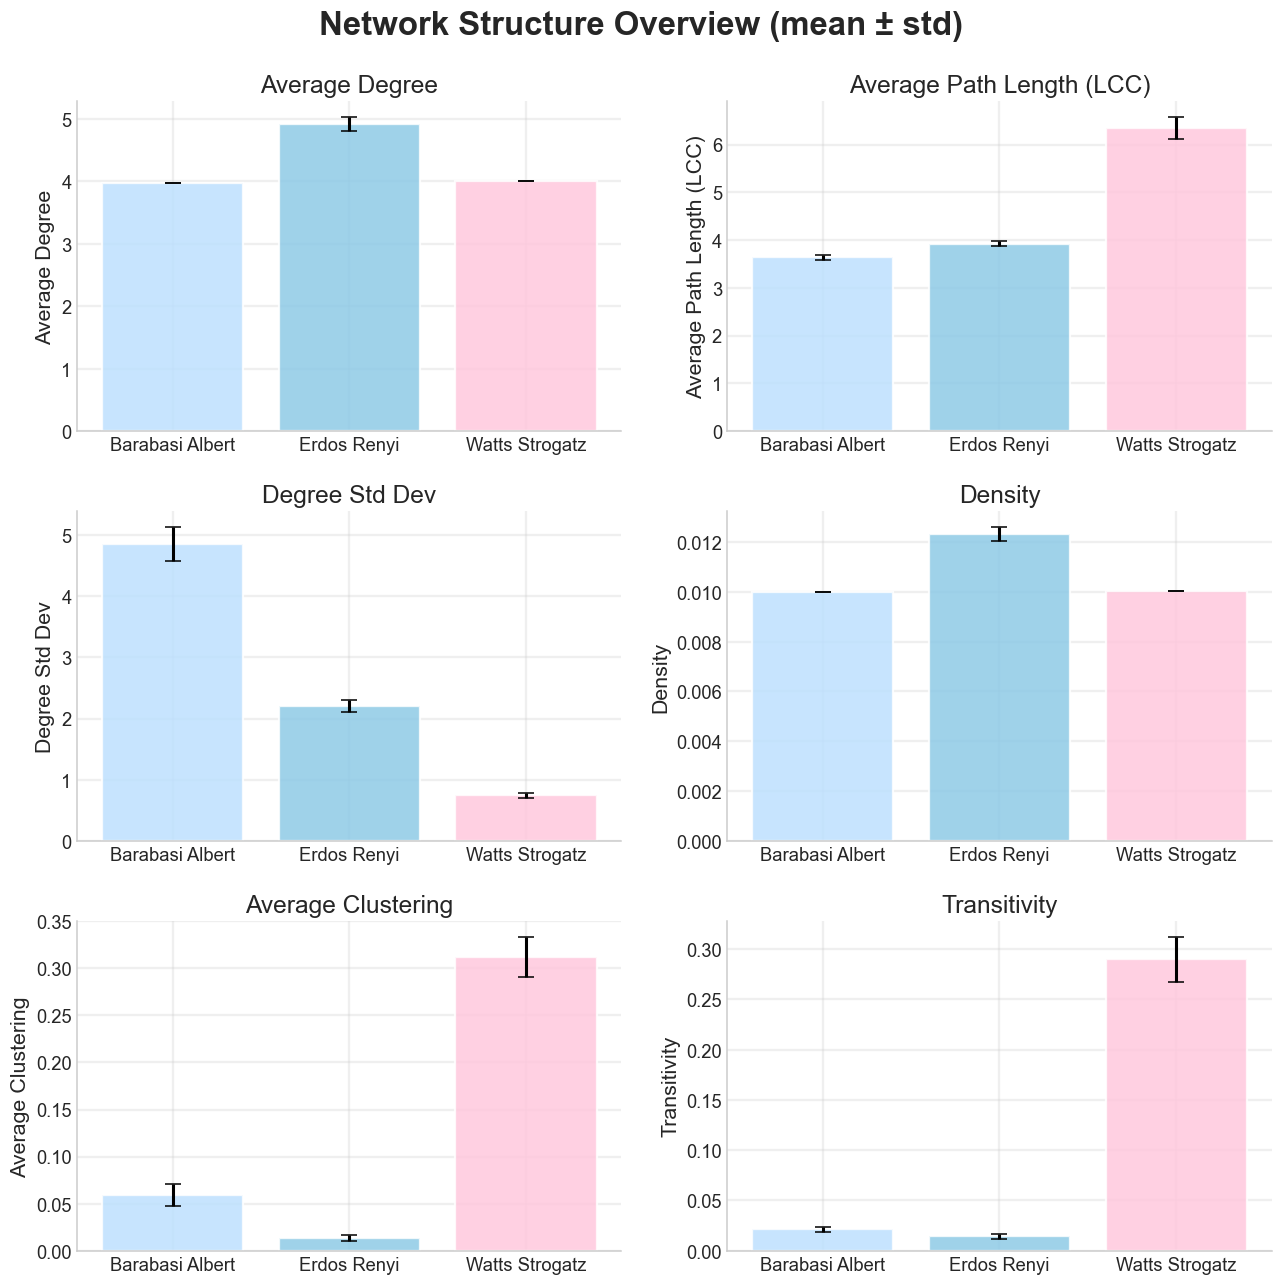

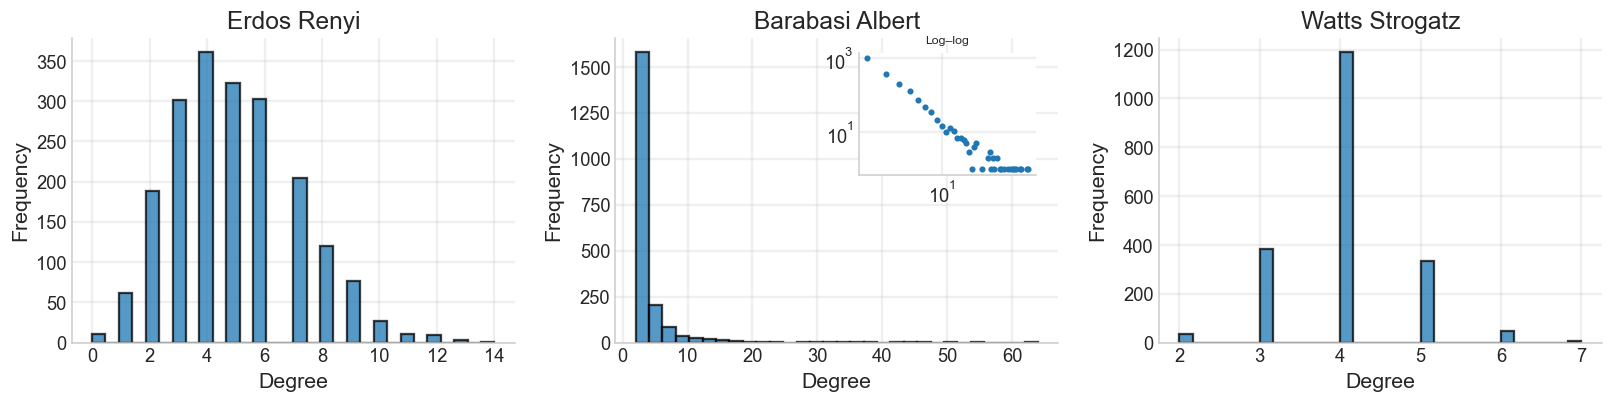

In [227]:
plot = Plotter(sim, pretty_style=True)
plot.structure_overview()

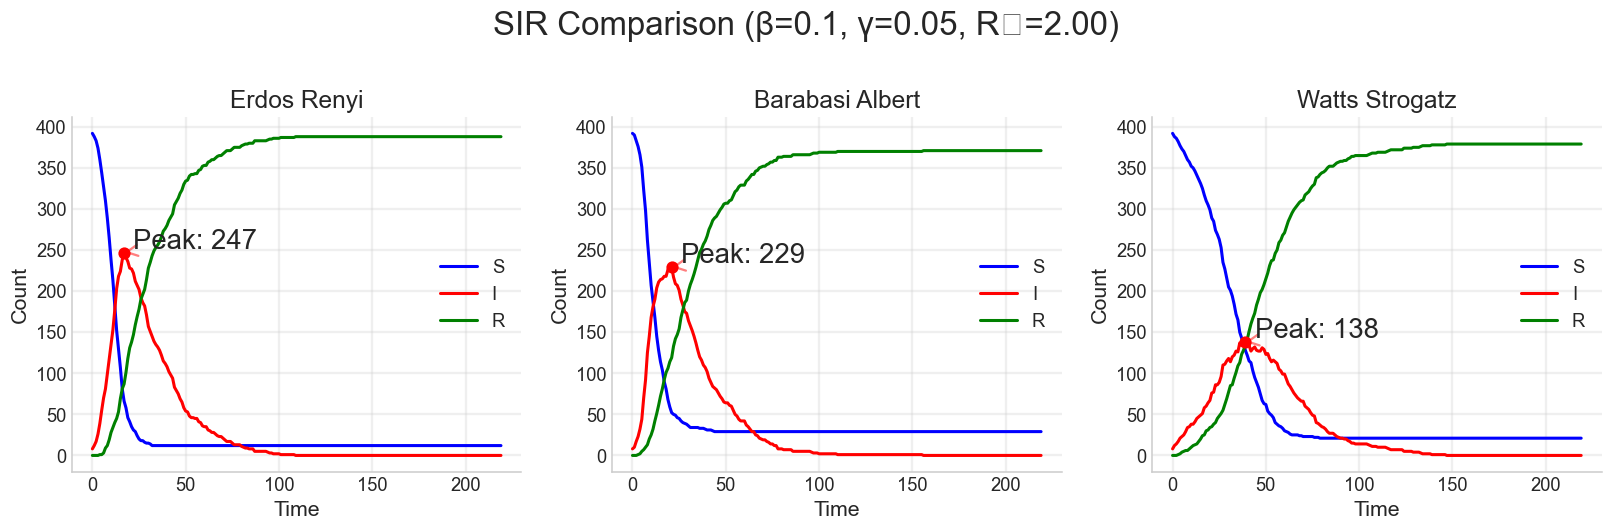

In [228]:
plot.sir_comparison(beta=0.10, gamma=0.05, fraction_infected=0.02, iterations=220)

   n_nodes  n_edges   density  avg_degree  std_degree  min_degree  max_degree  \
0      400      997  0.012494       4.985    2.082012         0.0        11.0   
1      400      953  0.011942       4.765    2.284683         0.0        12.0   
2      400      953  0.011942       4.765    2.284683         0.0        12.0   
3      400      994  0.012456       4.970    2.275764         0.0        13.0   
4      400      994  0.012456       4.970    2.275764         0.0        13.0   
5      400      969  0.012143       4.845    2.101422         0.0        13.0   
6      400      997  0.012494       4.985    2.082012         0.0        11.0   
7      400      953  0.011942       4.765    2.284683         0.0        12.0   

   second_moment_k2  degree_heterogeneity  tau_c_mean_over_second  ...  \
0            29.185              0.869564                0.170807  ...   
1            27.925              1.095441                0.170636  ...   
2            27.925              1.095441       

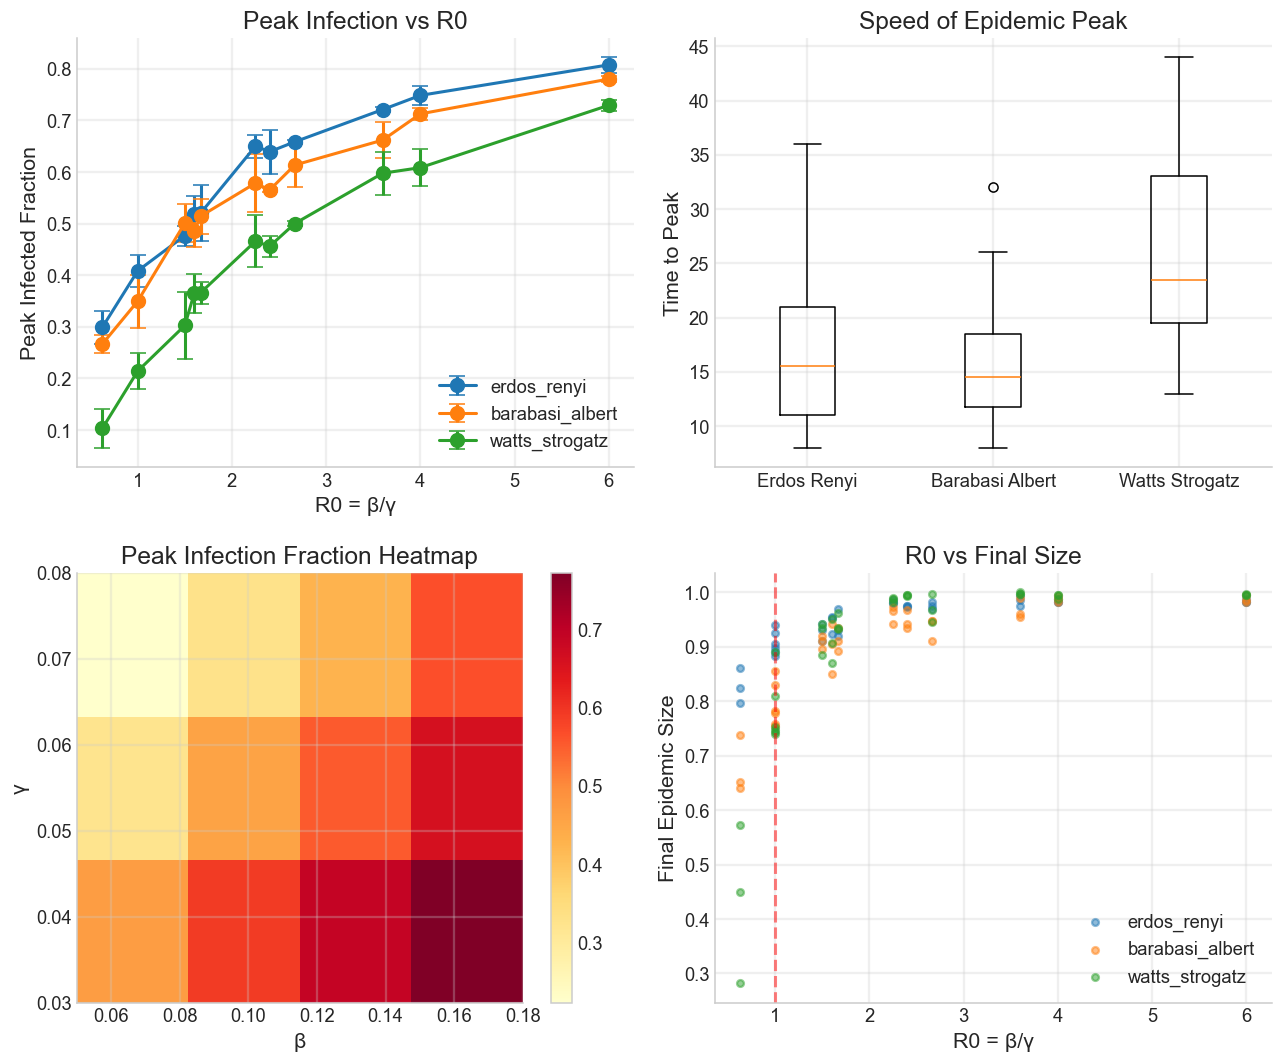

In [229]:
betas  = [0.05, 0.08, 0.12, 0.18]
gammas = [0.03, 0.05, 0.08]
df_sweep = sim.experiment_parameter_sweep(
    n_repetitions=3,
    beta_values=betas,
    gamma_values=gammas
)

print(df_sweep.head(8))
plot.parameter_sweep(df_sweep)

In [230]:
fractions = [0.005, 0.01, 0.02, 0.05]   # 0.5% to 5%
df_ic = sim.experiment_initial_conditions(
    beta=0.06, gamma=0.05,               # near-threshold: structure differences visible
    iterations=220,
    fractions=fractions,
    repetitions=5,
)
print(df_ic.groupby(['network_type','strategy'])[['peak_frac','time_to_peak','final_size_frac']].mean().round(3))


                             peak_frac  time_to_peak  final_size_frac
network_type    strategy                                             
barabasi_albert high_degree      0.402         20.75            0.854
                low_degree       0.416         21.15            0.861
                random           0.401         20.55            0.851
erdos_renyi     high_degree      0.457         22.45            0.927
                low_degree       0.457         23.35            0.928
                random           0.456         22.30            0.927
watts_strogatz  high_degree      0.256         35.15            0.842
                low_degree       0.254         42.30            0.849
                random           0.252         36.35            0.841


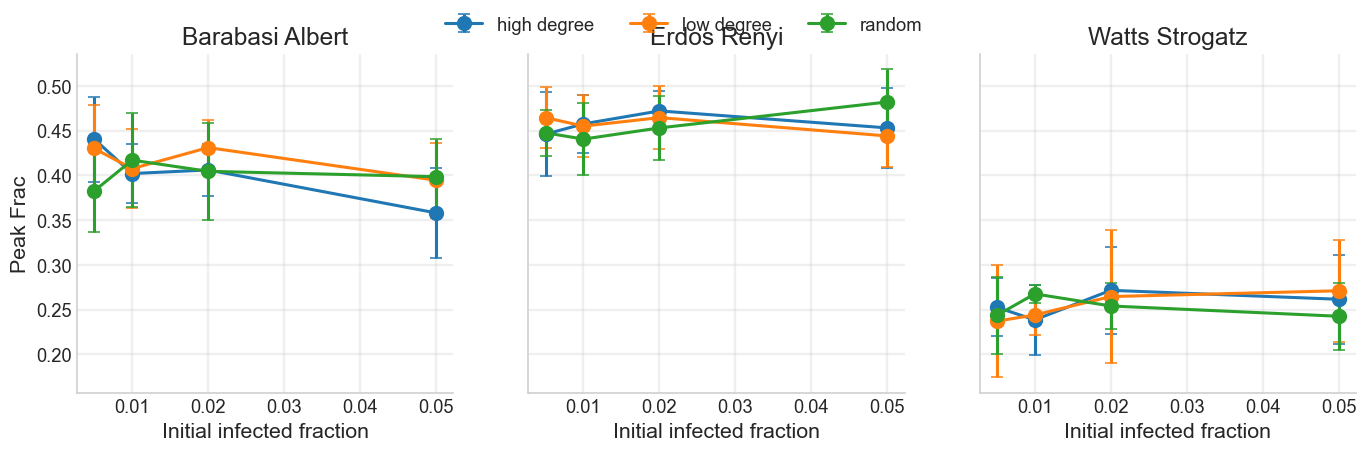

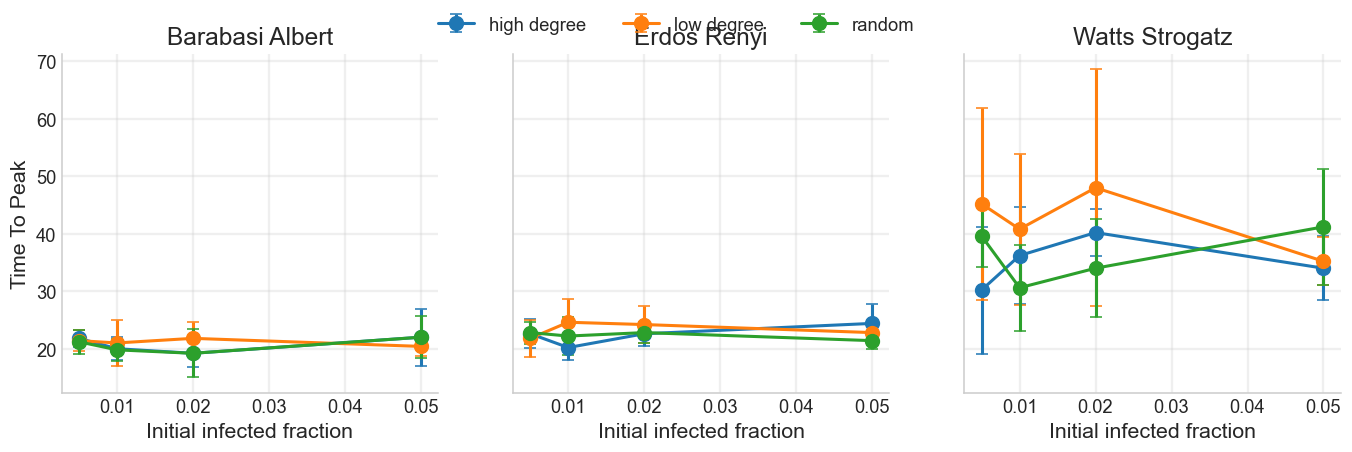

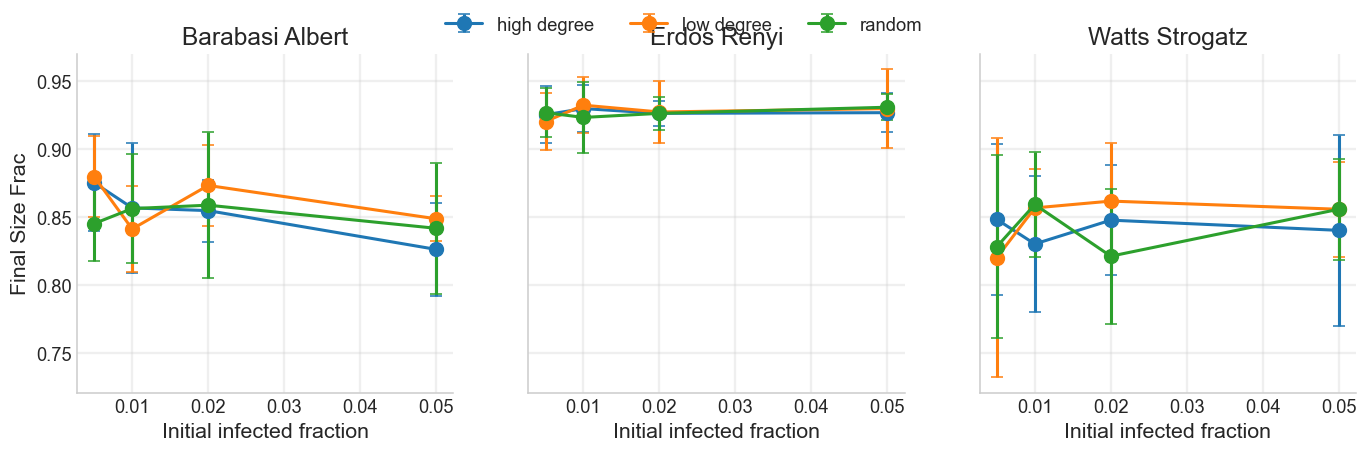

In [232]:
plot.fraction_effects(df_ic, metric='peak_frac')     
plot.fraction_effects(df_ic, metric='time_to_peak')
plot.fraction_effects(df_ic, metric='final_size_frac')

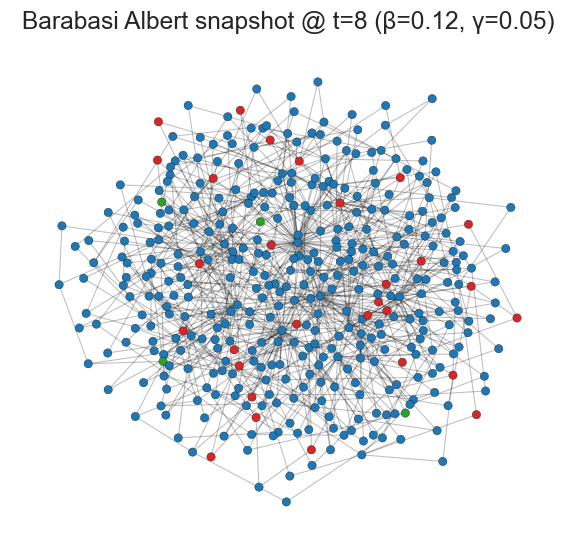

In [238]:
# Example of network image at a some t after outbreak start

plot.epidemic_snapshot(
    network_type='barabasi_albert', instance=0,
    beta=0.12, gamma=0.05,
    fraction_infected=0.1,
    iterations=220, t=8,
    layout='kamada_kawai'
)

### Sociopatterns Experiment

The sociopatterns dataset has 374 nodes and 1265 egdes. The nodes are people and edges exist if two people spent time near each other during the conference.

NOTE: Disregard weights that indicae how long people were in range of one another. Assume all contacts involve equal length and hence equal chance of transmission.

In [245]:
sim = NetworkSimulator(seed=42)

# Load the dataset
Gsp = sim.load_sociopatterns(
    "data/transmission_network.csv",  # path
    threshold=0.0,        
    giant_component=True, # keep only the main connected cluster
    relabel_to_int=True  # relabel node IDs to integers
)

[Sociopatterns] N=354, L=1263, ⟨k⟩=7.14


In [246]:
print("Nodes:", Gsp.number_of_nodes())
print("Edges:", Gsp.number_of_edges())

Nodes: 354
Edges: 1263


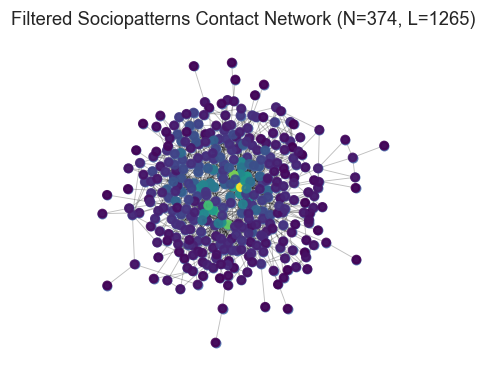

In [257]:
plotter = Plotter(sim)
plt.figure(figsize=(4, 4))
pos = nx.kamada_kawai_layout(Gsp)       # good for human contact networks
nx.draw_networkx_nodes(Gsp, pos, node_size=25, node_color="#4C72B0", alpha=0.9)
nx.draw_networkx_edges(Gsp, pos, alpha=0.25, width=0.6)
deg = [d for _, d in Gsp.degree()]
nx.draw_networkx_nodes(Gsp, pos, node_color=deg, cmap="viridis",
                       node_size=25, alpha=0.9)
plt.title("Filtered Sociopatterns Contact Network (N=374, L=1265)", fontsize=12)
plt.axis("off")
plt.show()